In [ ]:
# uses the second level models to calculate the slope over the five encounters per task/contrast

In [8]:
import os
import numpy as np
import pandas as pd
import nibabel as nib
import nilearn
import json
import datetime
import pickle
import seaborn as sns
import gc
import psutil
import math
import scipy.stats as stats
from matplotlib.patches import Patch
from nilearn import plotting
from nilearn.glm.first_level import FirstLevelModel
from nilearn.glm.second_level import SecondLevelModel
from nilearn.glm import threshold_stats_img
from nilearn.image import concat_imgs, mean_img, index_img
from nilearn.reporting import make_glm_report
from nilearn import masking, image
from nilearn import datasets
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from collections import defaultdict
from nilearn.maskers import NiftiLabelsMasker
from nilearn.plotting.find_cuts import find_cut_slices
import nibabel as nib


# Import shared utilities and configuration
# need to do it this way because in a sub-directory (later turn config and utils into part of a package)
from utils import (
    TASKS, CONTRASTS, SUBJECTS, SESSIONS, ENCOUNTERS,
    build_first_level_contrast_map_path, is_valid_contrast_map, clean_z_map_data,
    convert_to_regular_dict, create_smor_atlas,load_smor_atlas, load_schaefer_atlas, cleanup_memory
)
from config import BASE_DIR, INPUT_LEVEL, OUTPUT_DIRS

In [2]:
compiled_req_contrasts = []
for task in TASKS:
    for contrast in CONTRASTS[task]:
        if (contrast not in compiled_req_contrasts):
            compiled_req_contrasts.append(contrast)

In [3]:
# schafer stuff
SCHAFER_PARCELLATED_DIR = 'processed_data_dfs/schafer400_dfs'
schafer_files = {'mean':f'discovery_parcel_indiv_mean_updated'}
schafer_date_updated = '1001'
indices = [1,2,3]
# Get schaefer atlas
SCHAEFER = load_schaefer_atlas()
SCHAEFER_IMG = nib.load(SCHAEFER.maps)
SCHAEFER_DATA = SCHAEFER_IMG.get_fdata()

# smorgasbord stuff
SMORG_PARCELLATED_DIR = 'processed_data_dfs/smor_parcel_dfs'
smor_files = {'mean':f'discovery_parcel_indiv_mean_updated'}
smor_date_updated = '1117'
indices = [1,2,3]
# get smorgasbord atlas
smorgasbord_atlas = load_smor_atlas()
SMORG_IMG = smorgasbord_atlas.maps
SMORG_DATA = SMORG_IMG.get_fdata()

req_atlas = "smor"

# Select atlas configuration
if req_atlas == "schafer":
    main_dir = SCHAFER_PARCELLATED_DIR
    main_files = schafer_files
    date_updated = schafer_date_updated
    atlas_obj = SCHAEFER
    atlas_img = SCHAEFER_IMG
    atlas_data = SCHAEFER_DATA
elif req_atlas == "smor":
    main_dir = SMORG_PARCELLATED_DIR
    main_files = smor_files
    date_updated = smor_date_updated
    atlas_obj = smorgasbord_atlas
    atlas_img = SMORG_IMG
    atlas_data = SMORG_DATA
else:
    raise ValueError(f"Unknown atlas: {req_atlas}. Use 'schafer' or 'smor'")

Loading Schaefer 400 atlas...


[get_dataset_dir] Dataset found in /home/users/nklevak/nilearn_data/schaefer_2018

Atlas loaded with 400 regions
Atlas shape: (91, 109, 91)
Loading Smorgasbord atlas...
Atlas loaded with 429 regions
Atlas shape: (193, 229, 193)


In [10]:
# load all the second level models (z scores)

def load_all_zmaps(output_dir=OUTPUT_DIRS['second_level_models']):
    """
    Load all saved z-maps from the directory structure.
    
    Returns:
    --------
    zmaps_dict : nested dict
        Dictionary organized as zmaps[task][contrast][encounter] = NIfTI image
    """
    zmaps = defaultdict(lambda: defaultdict(dict))
    
    for task in os.listdir(output_dir):
        task_dir = os.path.join(output_dir, task)
        
        if not os.path.isdir(task_dir):
            continue
            
        for contrast in os.listdir(task_dir):
            contrast_dir = os.path.join(task_dir, contrast)
            
            if not os.path.isdir(contrast_dir):
                continue
            
            # Find all .nii.gz files in this directory
            for filename in os.listdir(contrast_dir):
                if filename.endswith('.nii.gz'):
                    # Parse encounter number from filename
                    # Format: {task}_{contrast}_encounter{N}.nii.gz
                    try:
                        encounter_str = filename.split('encounter')[1].split('.')[0]
                        encounter_idx = int(encounter_str) - 1  # Convert to 0-indexed
                        
                        # Load the NIfTI file
                        filepath = os.path.join(contrast_dir, filename)
                        zmap = nib.load(filepath)
                        
                        zmaps[task][contrast][encounter_idx] = zmap
                        
                    except (IndexError, ValueError) as e:
                        print(f"Warning: Could not parse {filename}: {e}")
                        continue
    
    print(f"Loaded z-maps for {len(zmaps)} tasks")
    for task in zmaps:
        print(f"  {task}: {len(zmaps[task])} contrasts")
        for contrast in zmaps[task]:
            n_encounters = len(zmaps[task][contrast])
            print(f"    {contrast}: {n_encounters} encounters")
    
    return zmaps

# Load all zmaps
secondLevelZmaps = load_all_zmaps()

Loaded z-maps for 8 tasks
  cuedTS: 5 contrasts
    task_switch_cost: 5 encounters
    response_time: 5 encounters
    task_switch_cue_switch-task_stay_cue_stay: 5 encounters
    cue_switch_cost: 5 encounters
    task-baseline: 5 encounters
  directedForgetting: 3 contrasts
    response_time: 5 encounters
    neg-con: 5 encounters
    task-baseline: 5 encounters
  goNogo: 4 contrasts
    response_time: 4 encounters
    nogo_success-go: 4 encounters
    nogo_success: 4 encounters
    task-baseline: 4 encounters
  stopSignal: 9 contrasts
    response_time: 5 encounters
    stop_success: 5 encounters
    stop_success-go: 5 encounters
    stop_failure-go: 5 encounters
    stop_failure-stop_success: 5 encounters
    stop_success-stop_failure: 5 encounters
    stop_failure: 5 encounters
    task-baseline: 5 encounters
    go: 5 encounters
  flanker: 2 contrasts
    incongruent-congruent: 5 encounters
    task-baseline: 5 encounters
  shapeMatching: 10 contrasts
    response_time: 5 encounter

In [12]:
# parcellate the second level maps and get the trajectories of the slopes:
def extract_parcel_slopes_from_second_level(secondLevelZmaps, atlas):
    """
    Extract parcel-wise slopes from second-level z-maps across encounters.
    Each point in the trajectory is a group-level z-statistic.
    """
    parcel_slopes = defaultdict(lambda: defaultdict(dict))
    
    # Create masker
    masker = NiftiLabelsMasker(
        labels_img=atlas.maps,
        standardize=False,
        strategy='mean'
    )
    
    # Get atlas labels
    atlas_labels = [label.decode('utf-8') if isinstance(label, bytes) else label 
                   for label in atlas.labels]
    
    for task in secondLevelZmaps:
        for contrast in secondLevelZmaps[task]:
            print(f"Processing {task}:{contrast}")
            
            # Collect z-maps and corresponding encounter numbers
            encounter_zmaps = []
            encounter_numbers = []
            
            for enc in sorted(secondLevelZmaps[task][contrast].keys()):
                zmap = secondLevelZmaps[task][contrast][enc]
                if zmap is not None:
                    encounter_zmaps.append(zmap)
                    encounter_numbers.append(enc)
            
            if len(encounter_zmaps) < 2:
                print(f"  Skipping - only {len(encounter_zmaps)} valid encounters")
                continue
            
            # Extract parcel values for each encounter
            parcel_values_by_encounter = []
            for zmap in encounter_zmaps:
                parcel_vals = masker.fit_transform(zmap).flatten()
                parcel_values_by_encounter.append(parcel_vals)
            
            # Stack into array: (n_encounters, n_parcels)
            parcel_array = np.array(parcel_values_by_encounter)
            encounter_array = np.array(encounter_numbers)
            n_parcels = parcel_array.shape[1]
            
            print(f"  Computing slopes for {n_parcels} parcels across {len(encounter_numbers)} encounters")
            
            # Compute slope for each parcel
            for parcel_idx, parcel_label in enumerate(atlas_labels):
                z_values = parcel_array[:, parcel_idx]
                
                # Fit linear regression
                slope, intercept = np.polyfit(encounter_array, z_values, 1)
                
                # Calculate R squared and p-value for the fit
                from scipy import stats
                slope_stat, intercept_stat, r_value, p_value, std_err = \
                    stats.linregress(encounter_array, z_values)
                
                parcel_slopes[task][contrast][parcel_label] = {
                    'slope': slope,
                    'intercept': intercept,
                    'r_squared': r_value**2,
                    'p_value': p_value,
                    'std_err': std_err,
                    'z_values': z_values.tolist(),
                    'encounters': encounter_array.tolist(),
                    'n_encounters': len(encounter_array)
                }
    
    return parcel_slopes

second_level_parcel_slopes = extract_parcel_slopes_from_second_level(
    secondLevelZmaps, 
    atlas_obj
)

Processing cuedTS:task_switch_cost
  Computing slopes for 429 parcels across 5 encounters
Processing cuedTS:response_time
  Computing slopes for 429 parcels across 5 encounters
Processing cuedTS:task_switch_cue_switch-task_stay_cue_stay
  Computing slopes for 429 parcels across 5 encounters
Processing cuedTS:cue_switch_cost
  Computing slopes for 429 parcels across 5 encounters
Processing cuedTS:task-baseline
  Computing slopes for 429 parcels across 5 encounters
Processing directedForgetting:response_time
  Computing slopes for 429 parcels across 5 encounters
Processing directedForgetting:neg-con
  Computing slopes for 429 parcels across 5 encounters
Processing directedForgetting:task-baseline
  Computing slopes for 429 parcels across 5 encounters
Processing goNogo:response_time
  Computing slopes for 429 parcels across 4 encounters
Processing goNogo:nogo_success-go
  Computing slopes for 429 parcels across 4 encounters
Processing goNogo:nogo_success
  Computing slopes for 429 parcels

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



AttributeError: Can't pickle local object 'extract_parcel_slopes_from_second_level.<locals>.<lambda>'

In [13]:
# Save to pickle
output_file = 'processed_data_dfs/second_level_parcel_slopes.pkl'
pickle_dict = convert_to_regular_dict(second_level_parcel_slopes)
with open(output_file, 'wb') as f:
    pickle.dump(pickle_dict, f)
print(f"Saved to {output_file}")

Saved to processed_data_dfs/second_level_parcel_slopes.pkl


In [18]:
# plot the same intercept plots as in 13_visualize_parcel_intercepts
# get fixed effects:
fixed_avg_parcel_traj_results = {}
fixed_filename = f"{main_dir}_fixed/discovery_parcel_averaged_across_{date_updated}_1.pkl"

with open(fixed_filename, 'rb') as f:
    fixed_avg_parcel_traj_results = pickle.load(f)

# restructure the avg fixed effects parcel df to be the same structure as the averaged parcel trajectories df:
for task in second_level_parcel_slopes.keys():
    for contrast in second_level_parcel_slopes[task].keys():
        df = fixed_avg_parcel_traj_results[task][contrast]
        
        fixed_avg_parcel_traj_results[task][contrast] = {
            row['region']: {
                'activation': row['activation'],
                'network': row['network'],
                'roi_value': row['roi_value']
            }
            for _, row in df.iterrows()
        }

# create the dfs
avg_activations = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))

for task in second_level_parcel_slopes.keys():
    for contrast in second_level_parcel_slopes[task].keys():
        for parcel in second_level_parcel_slopes[task][contrast].keys():
            avg_activations[task][contrast]["second_level_slope"].append(second_level_parcel_slopes[task][contrast][parcel]["slope"])
            avg_activations[task][contrast]["avg_fixed_effects_val"].append(fixed_avg_parcel_traj_results[task][contrast][parcel]["activation"])

In [21]:
# Calculate global limits across ALL tasks and contrasts (excluding response_time)
x_min, x_max = float('inf'), float('-inf')
y_min, y_max = float('inf'), float('-inf')

for task in avg_activations.keys():
    for contrast in avg_activations[task].keys():
        if (contrast == "response_time"):
            continue
            
        df = avg_activations[task][contrast]
        x_min = min(x_min, np.min(df["avg_fixed_effects_val"]))
        x_max = max(x_max, np.max(df["avg_fixed_effects_val"]))
        y_min = min(y_min, np.min(df["second_level_slope"]))
        y_max = max(y_max, np.max(df["second_level_slope"]))

# Add padding
x_padding = (x_max - x_min) * 0.05
y_padding = (y_max - y_min) * 0.05
x_min -= x_padding
x_max += x_padding
y_min -= y_padding
y_max += y_padding

print(x_min)
print(x_max)

-2.8946908271354954
2.4073213218860743


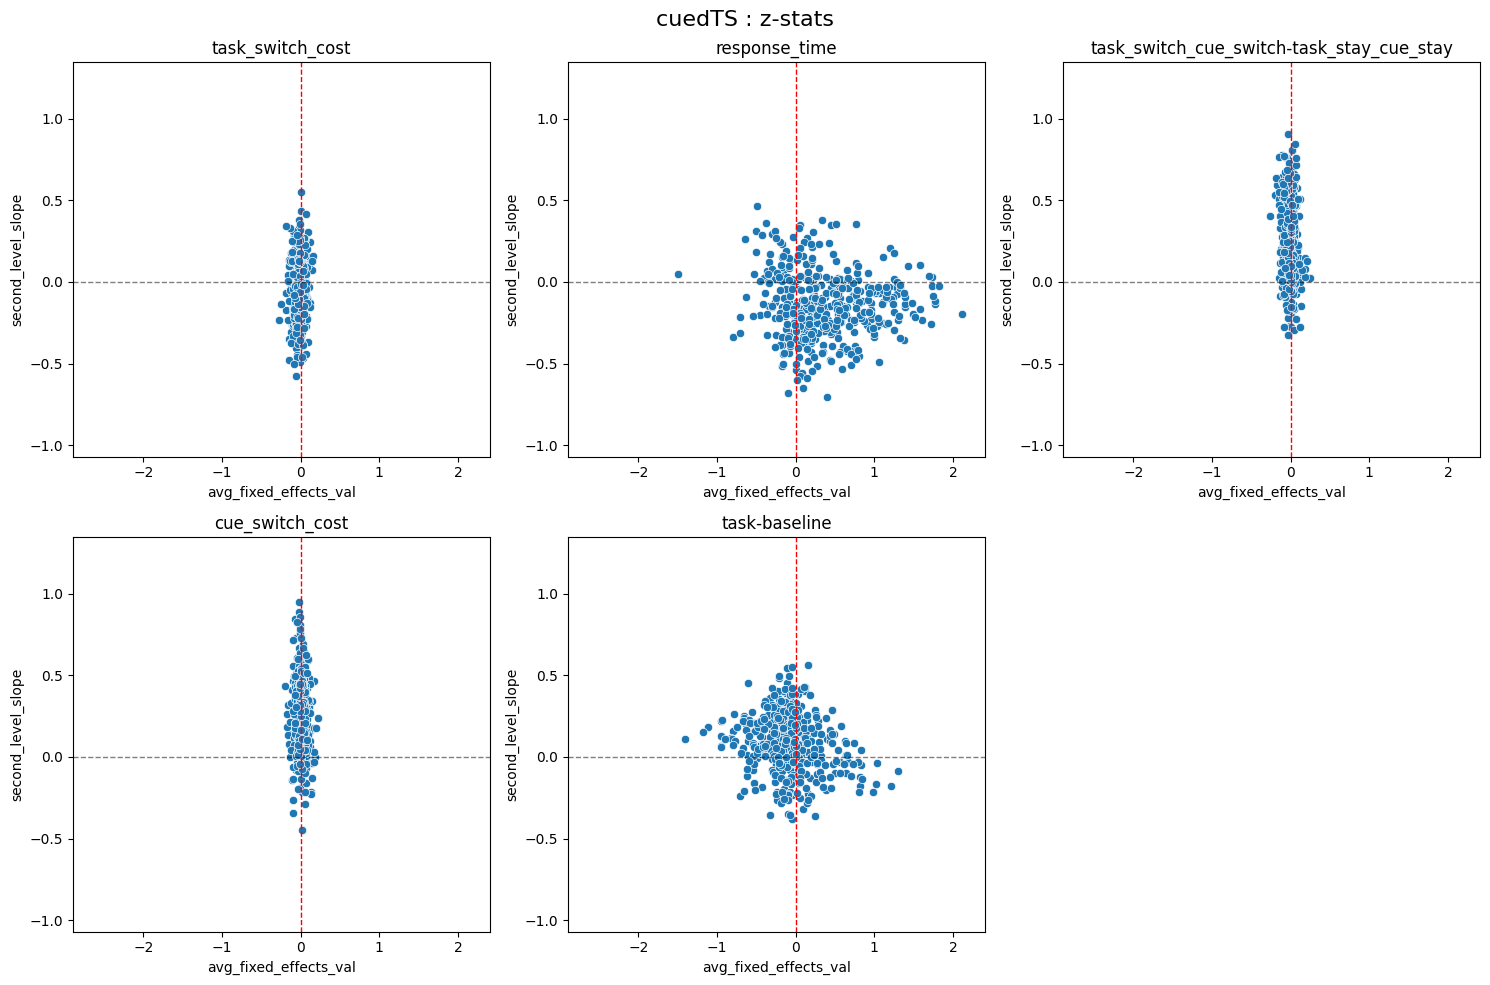

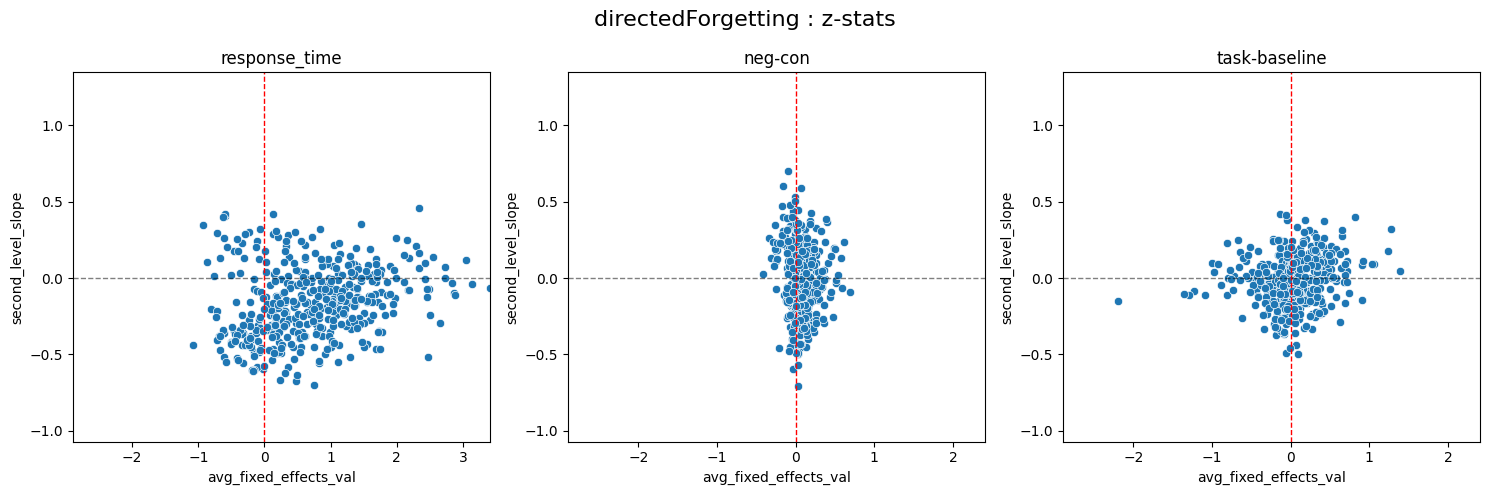

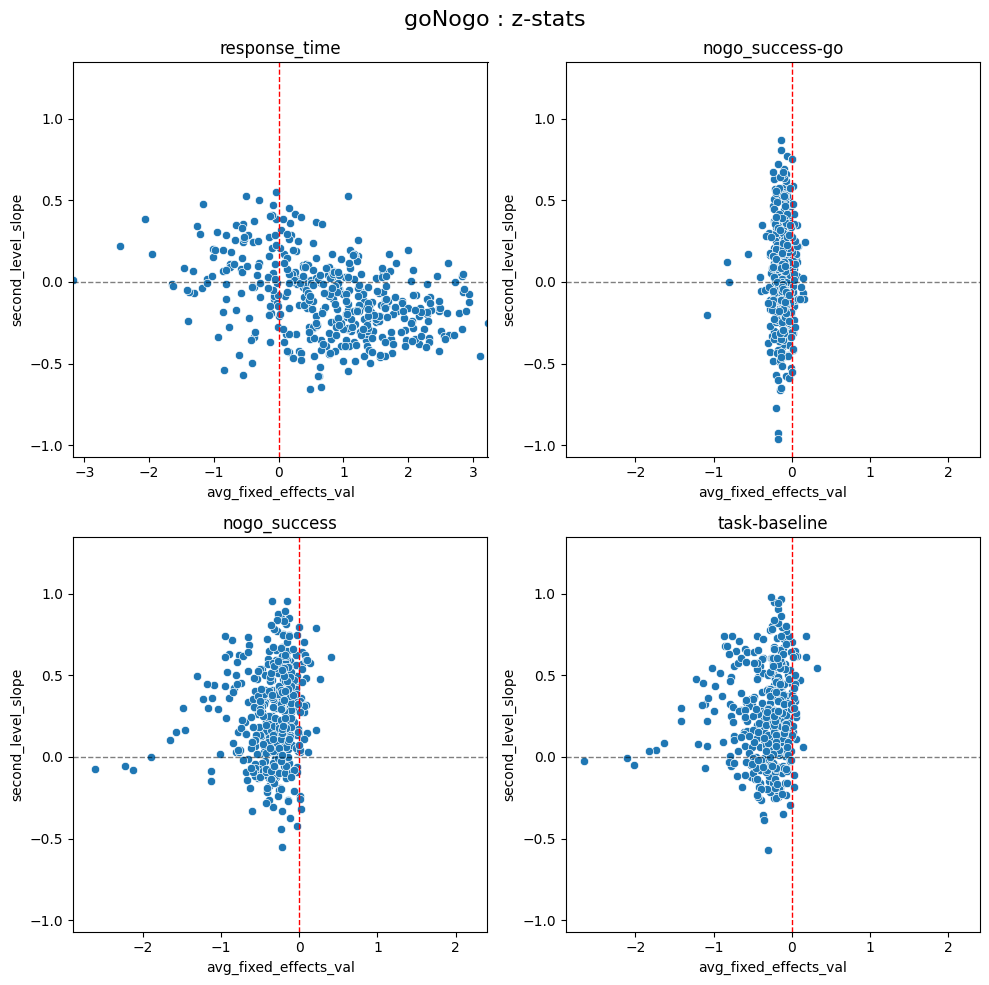

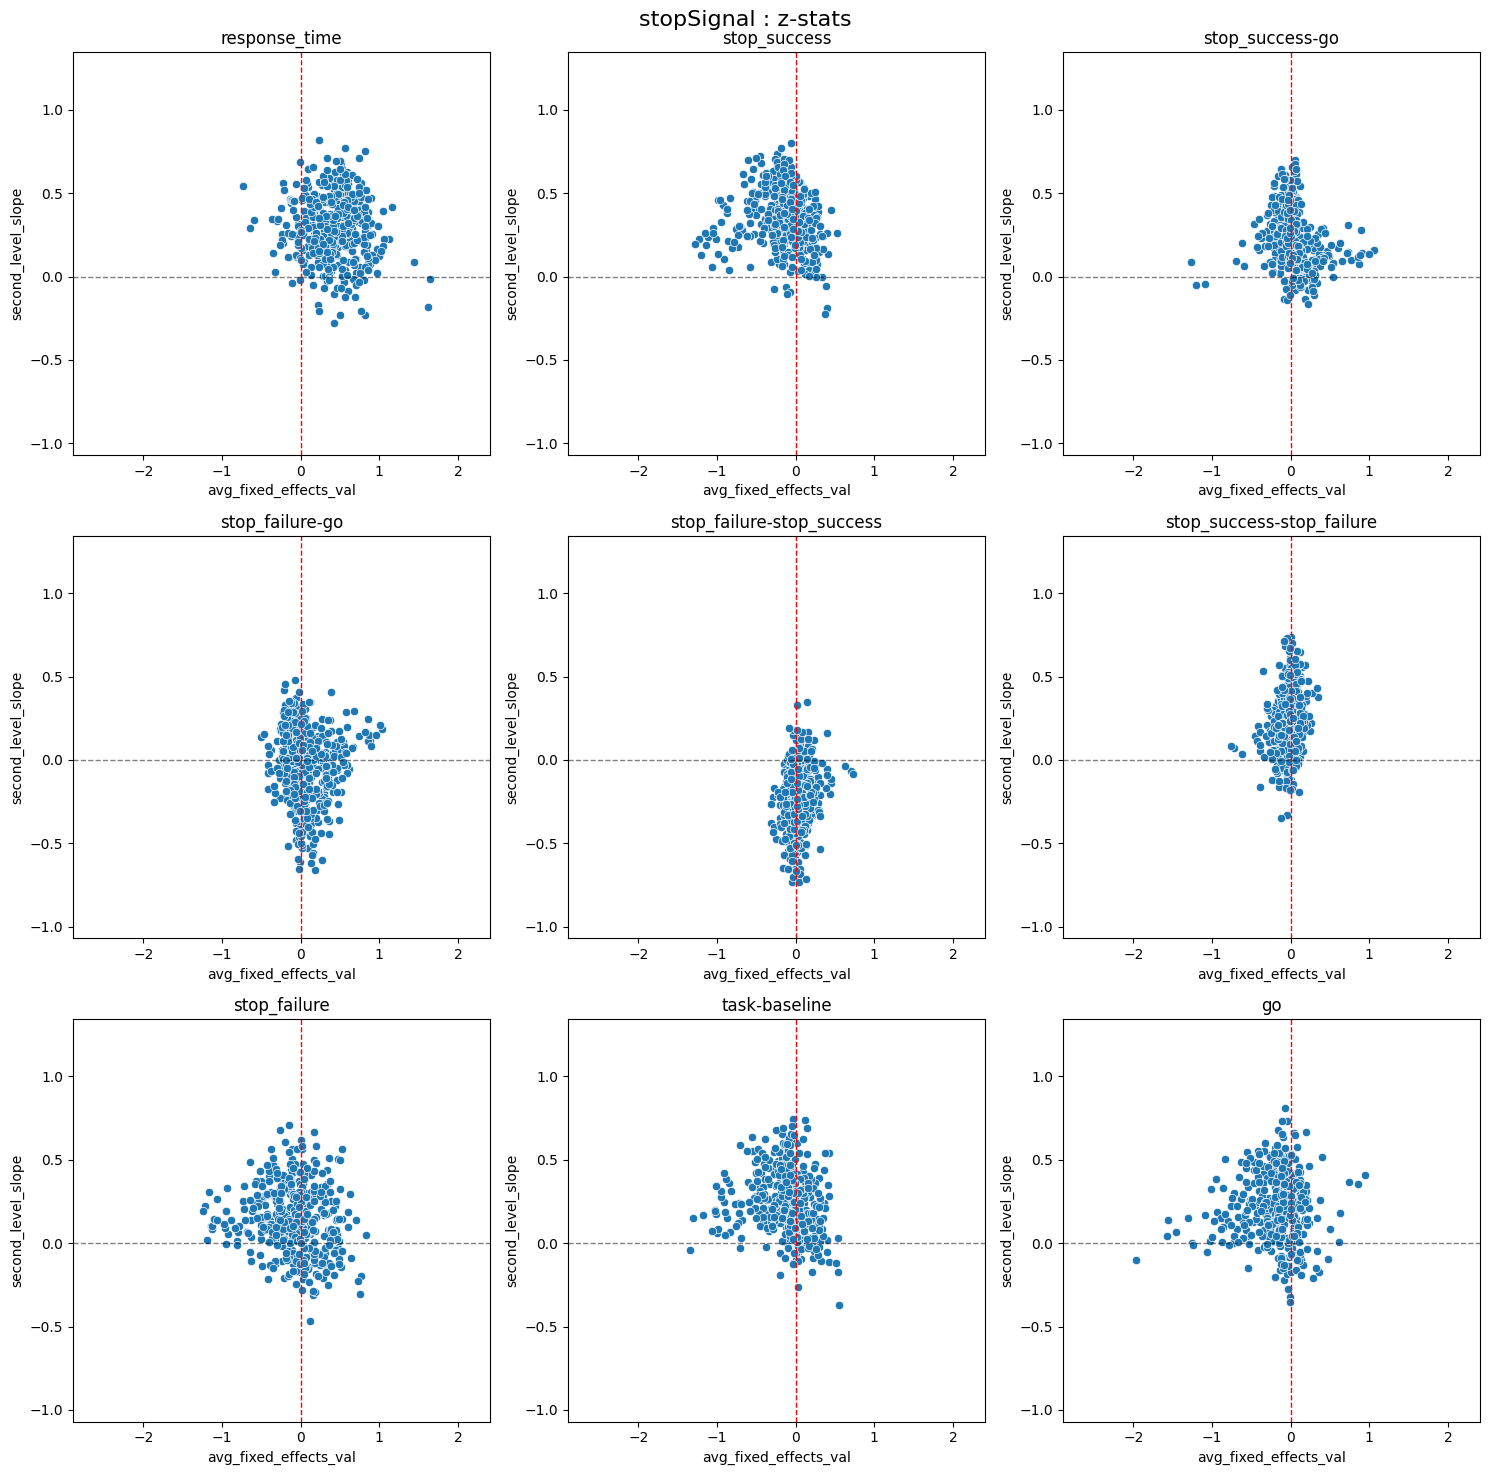

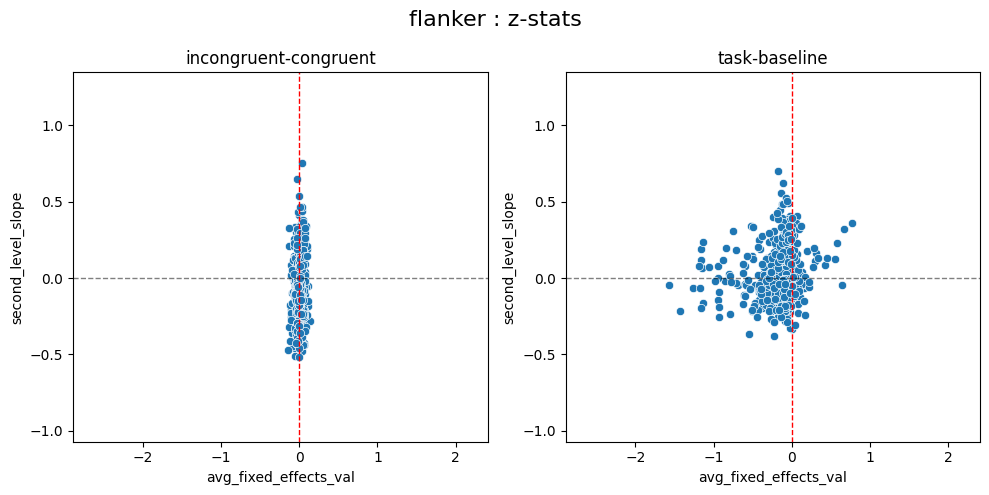

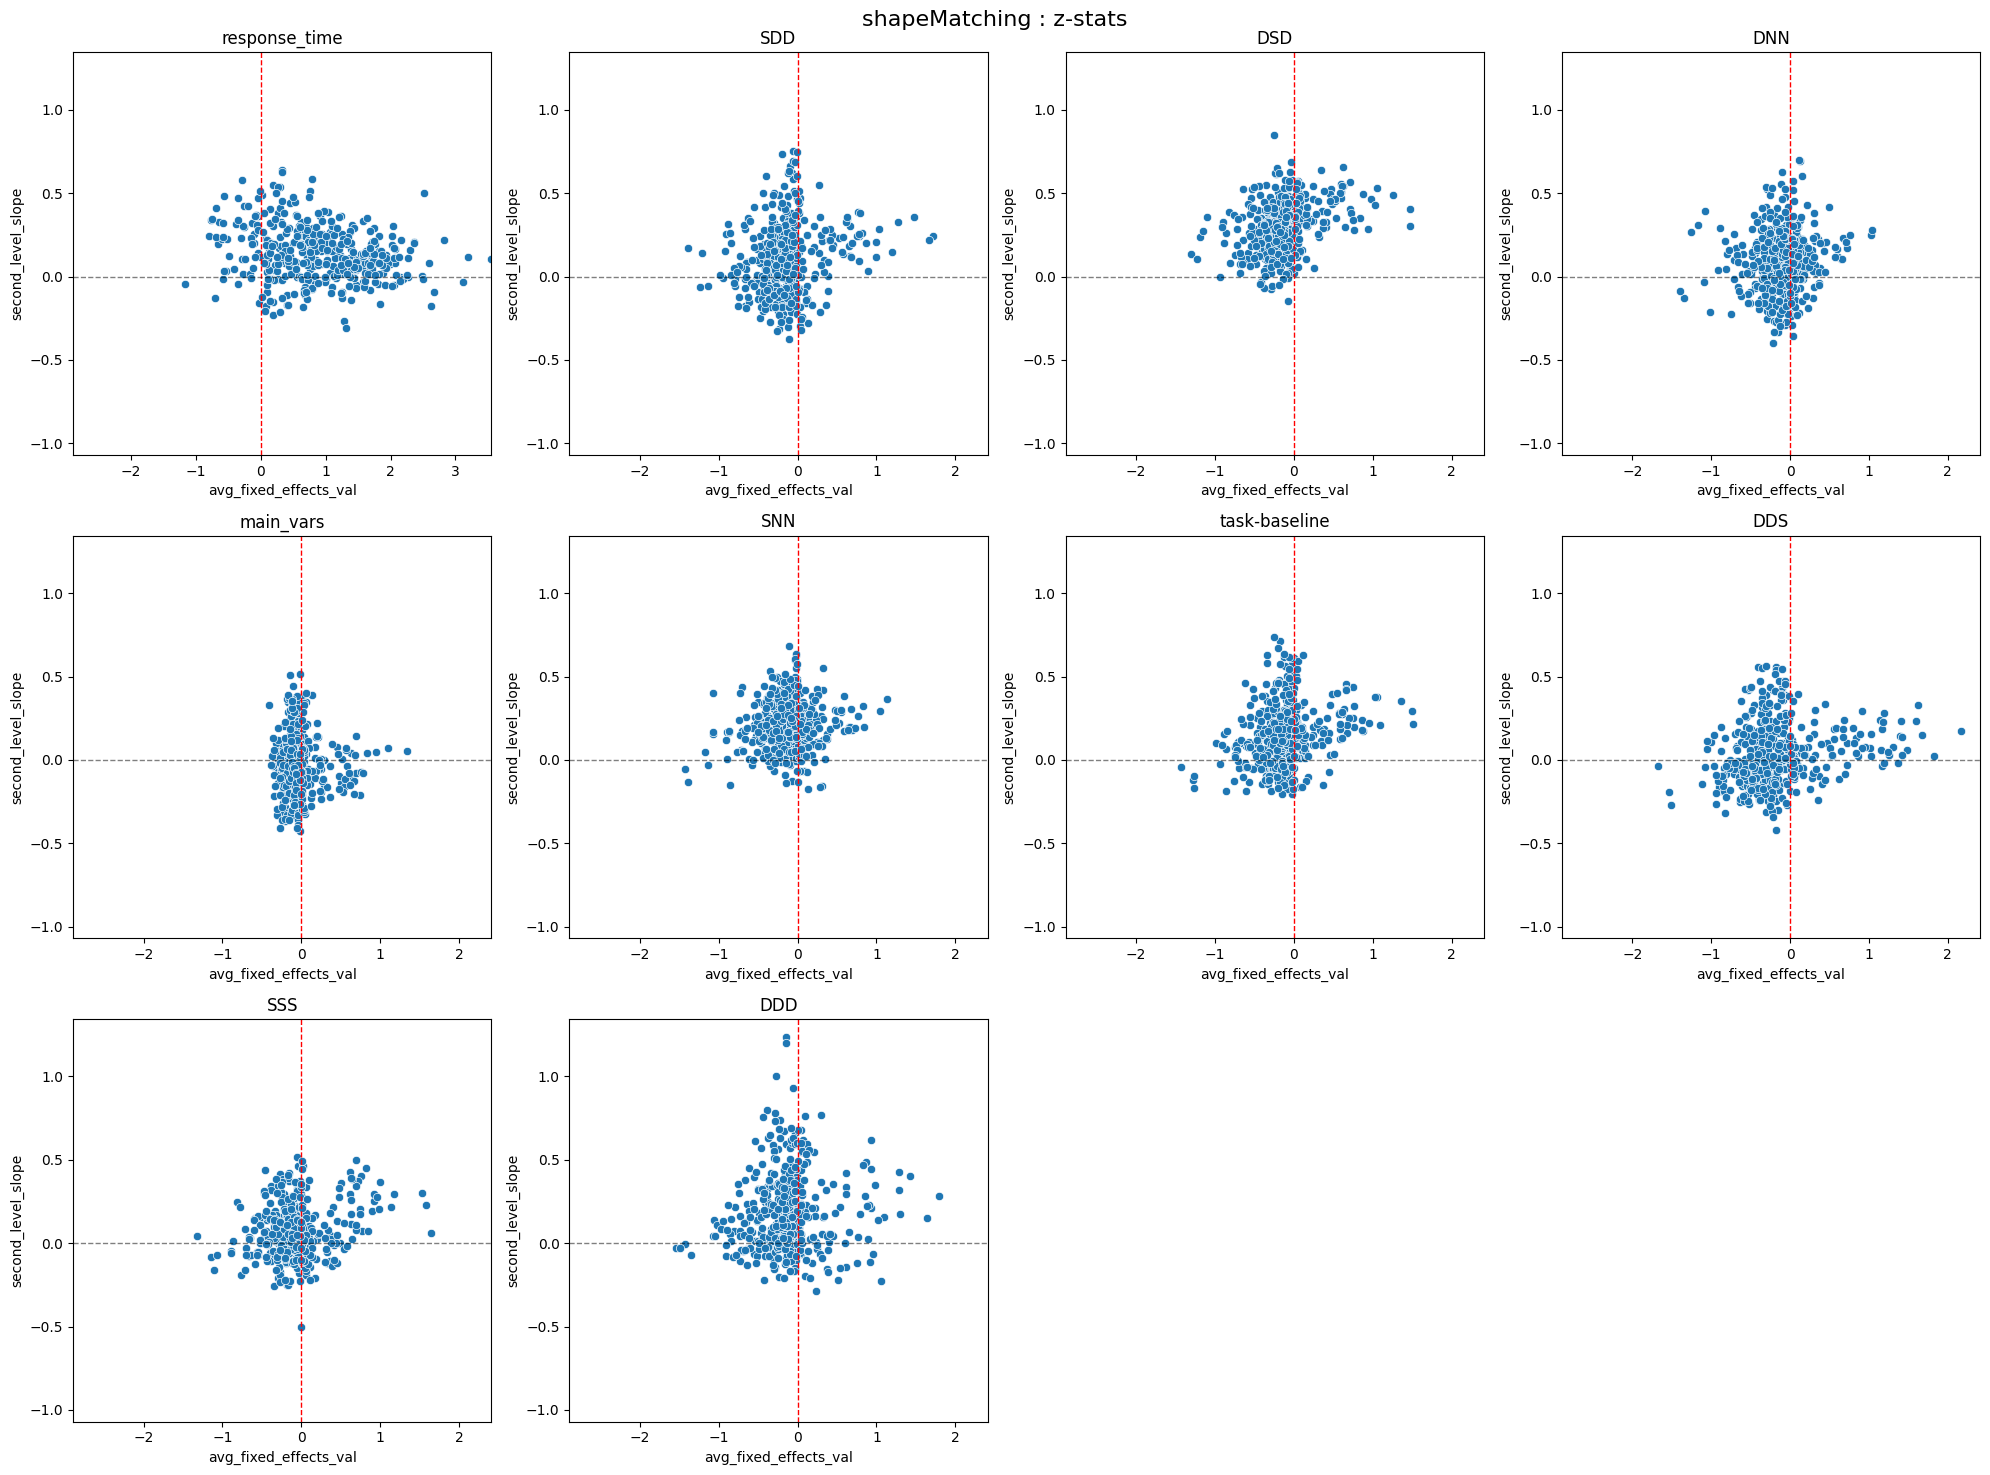

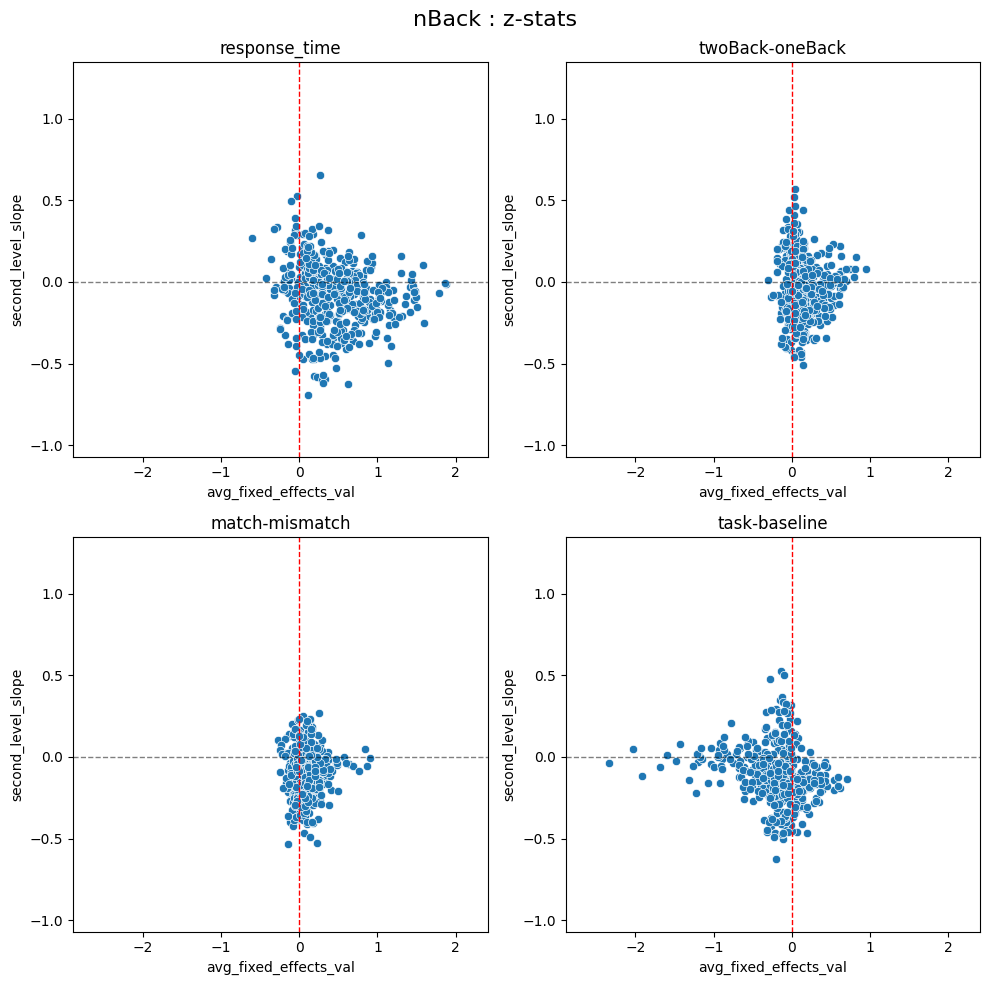

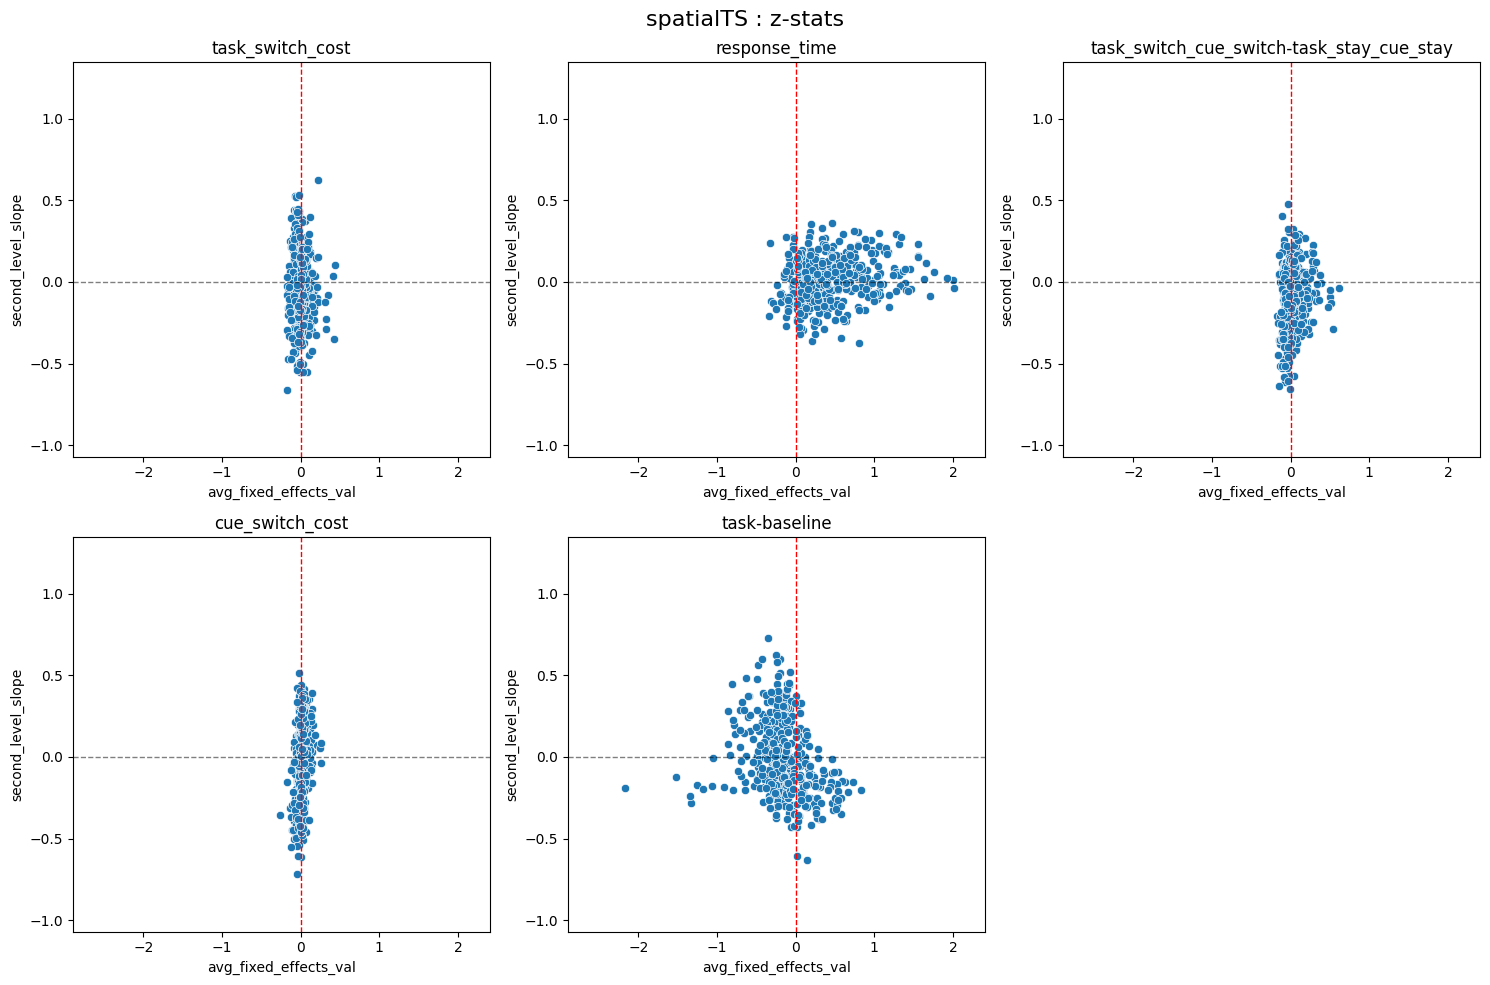

In [22]:
for task in avg_activations.keys():
    contrasts = list(avg_activations[task].keys())
    n_contrasts = len(contrasts)
    
    if n_contrasts <= 3:
        n_rows, n_cols = 1, n_contrasts
    elif n_contrasts <= 6:
        n_rows = 2
        n_cols = int(np.ceil(n_contrasts / 2))
    else:
        n_rows = 3
        n_cols = int(np.ceil(n_contrasts / 3))
    
    # Create subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 5*n_rows))
    
    # Flatten axes array for easier indexing
    if n_contrasts == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    
    for idx, contrast in enumerate(contrasts):
        sns.scatterplot(data=avg_activations[task][contrast], 
                       x="avg_fixed_effects_val", 
                       y="second_level_slope", 
                       ax=axes[idx])
        axes[idx].axvline(x=0, color='red', linestyle='--', linewidth=1)
        axes[idx].axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
        axes[idx].set_title(f"{contrast}")

        if (contrast != "response_time"):
            axes[idx].set_xlim(x_min, x_max)
            axes[idx].set_ylim(y_min, y_max)
        else: 
            rt_max_x = max(x_max, np.max(avg_activations[task][contrast]["avg_fixed_effects_val"]))
            rt_max_y = max(y_max, np.max(avg_activations[task][contrast]["second_level_slope"]))
            rt_min_x = min(x_min, np.min(avg_activations[task][contrast]["avg_fixed_effects_val"]))
            rt_min_y = min(y_min, np.min(avg_activations[task][contrast]["second_level_slope"]))
            axes[idx].set_xlim(rt_min_x, rt_max_x)
            axes[idx].set_ylim(rt_min_y, rt_max_y)
    
    # Hide any unused subplots
    for idx in range(n_contrasts, len(axes)):
        axes[idx].set_visible(False)
    
    fig.suptitle(f"{task} : z-stats", fontsize=16)
    plt.tight_layout()
    plt.show()

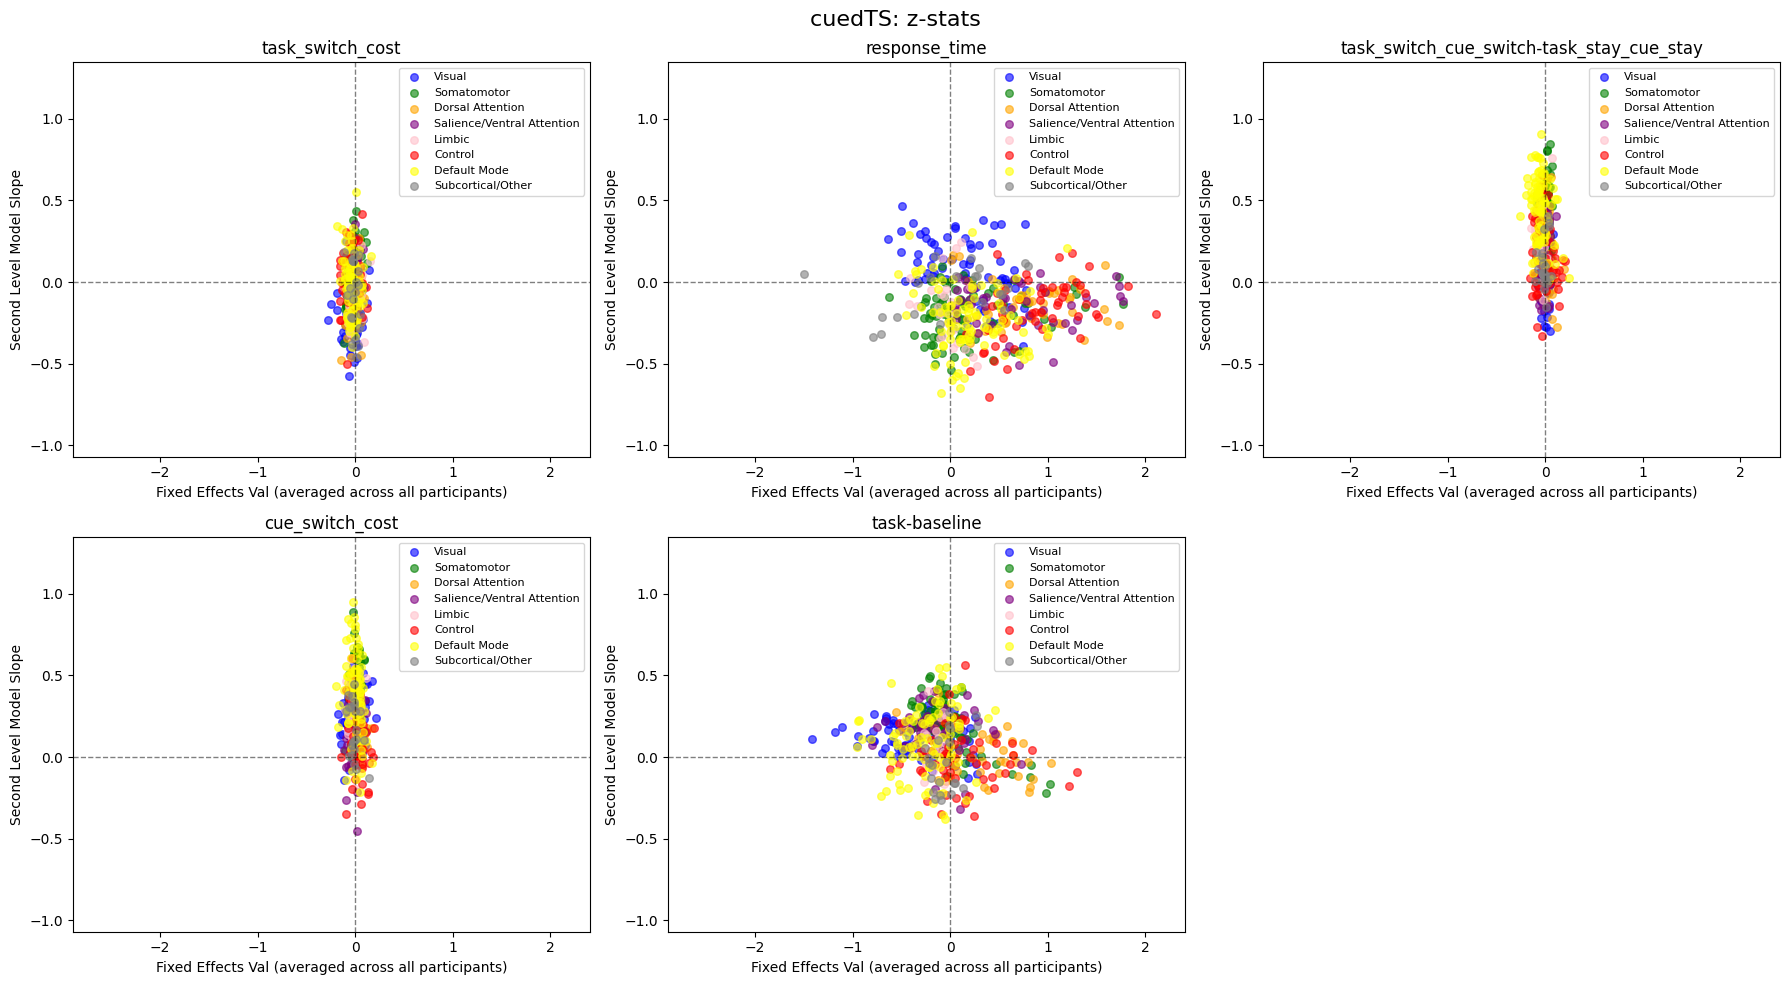

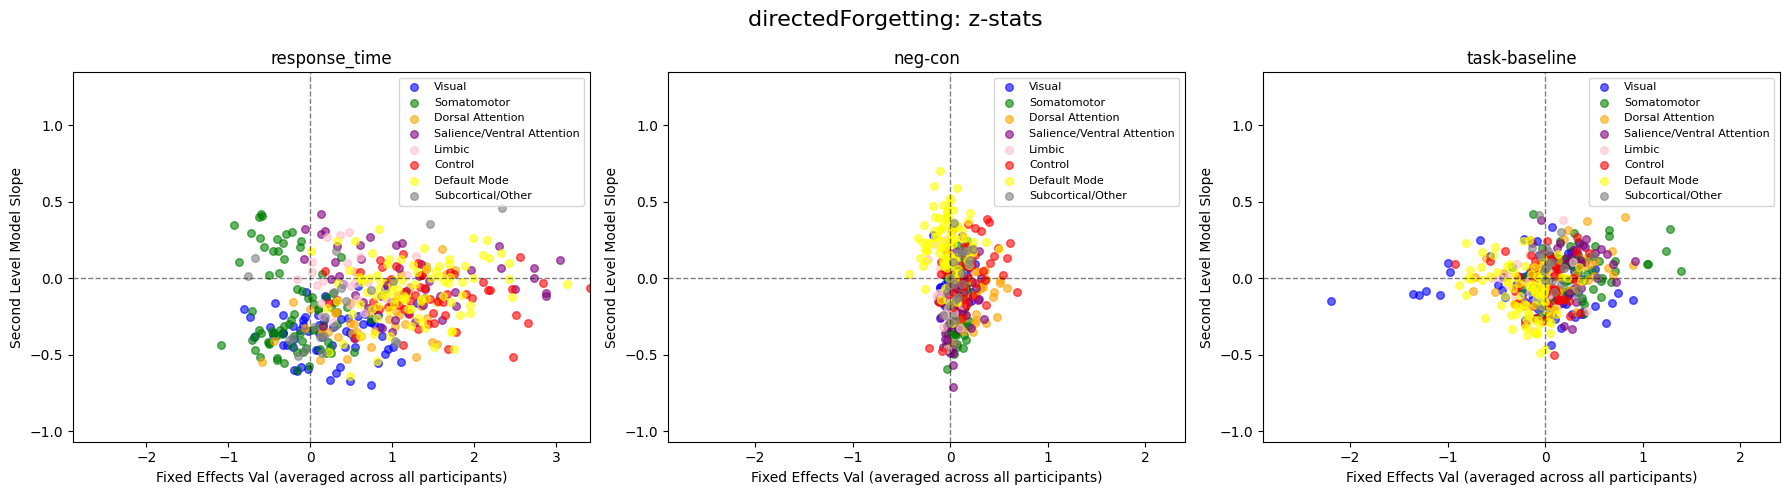

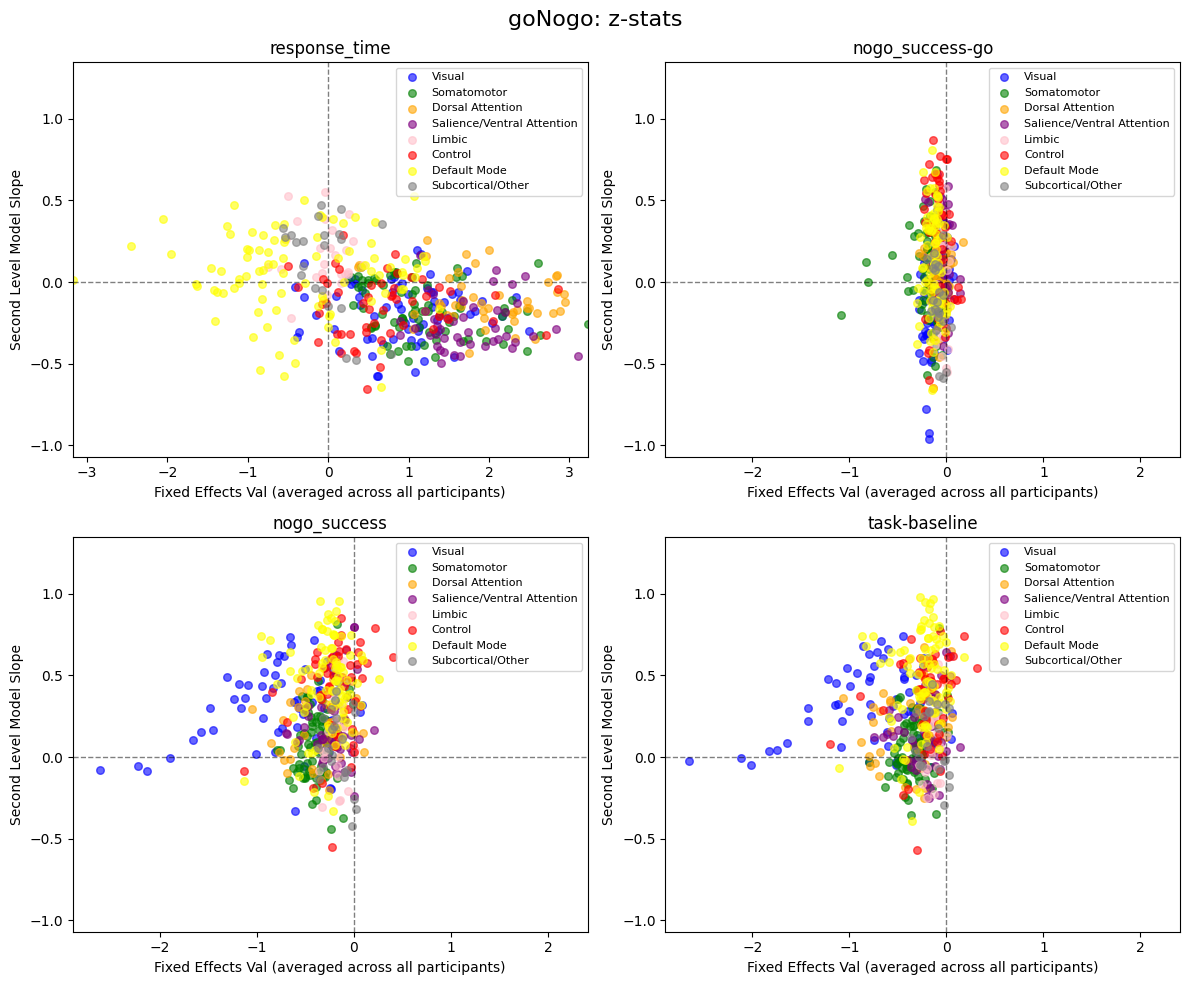

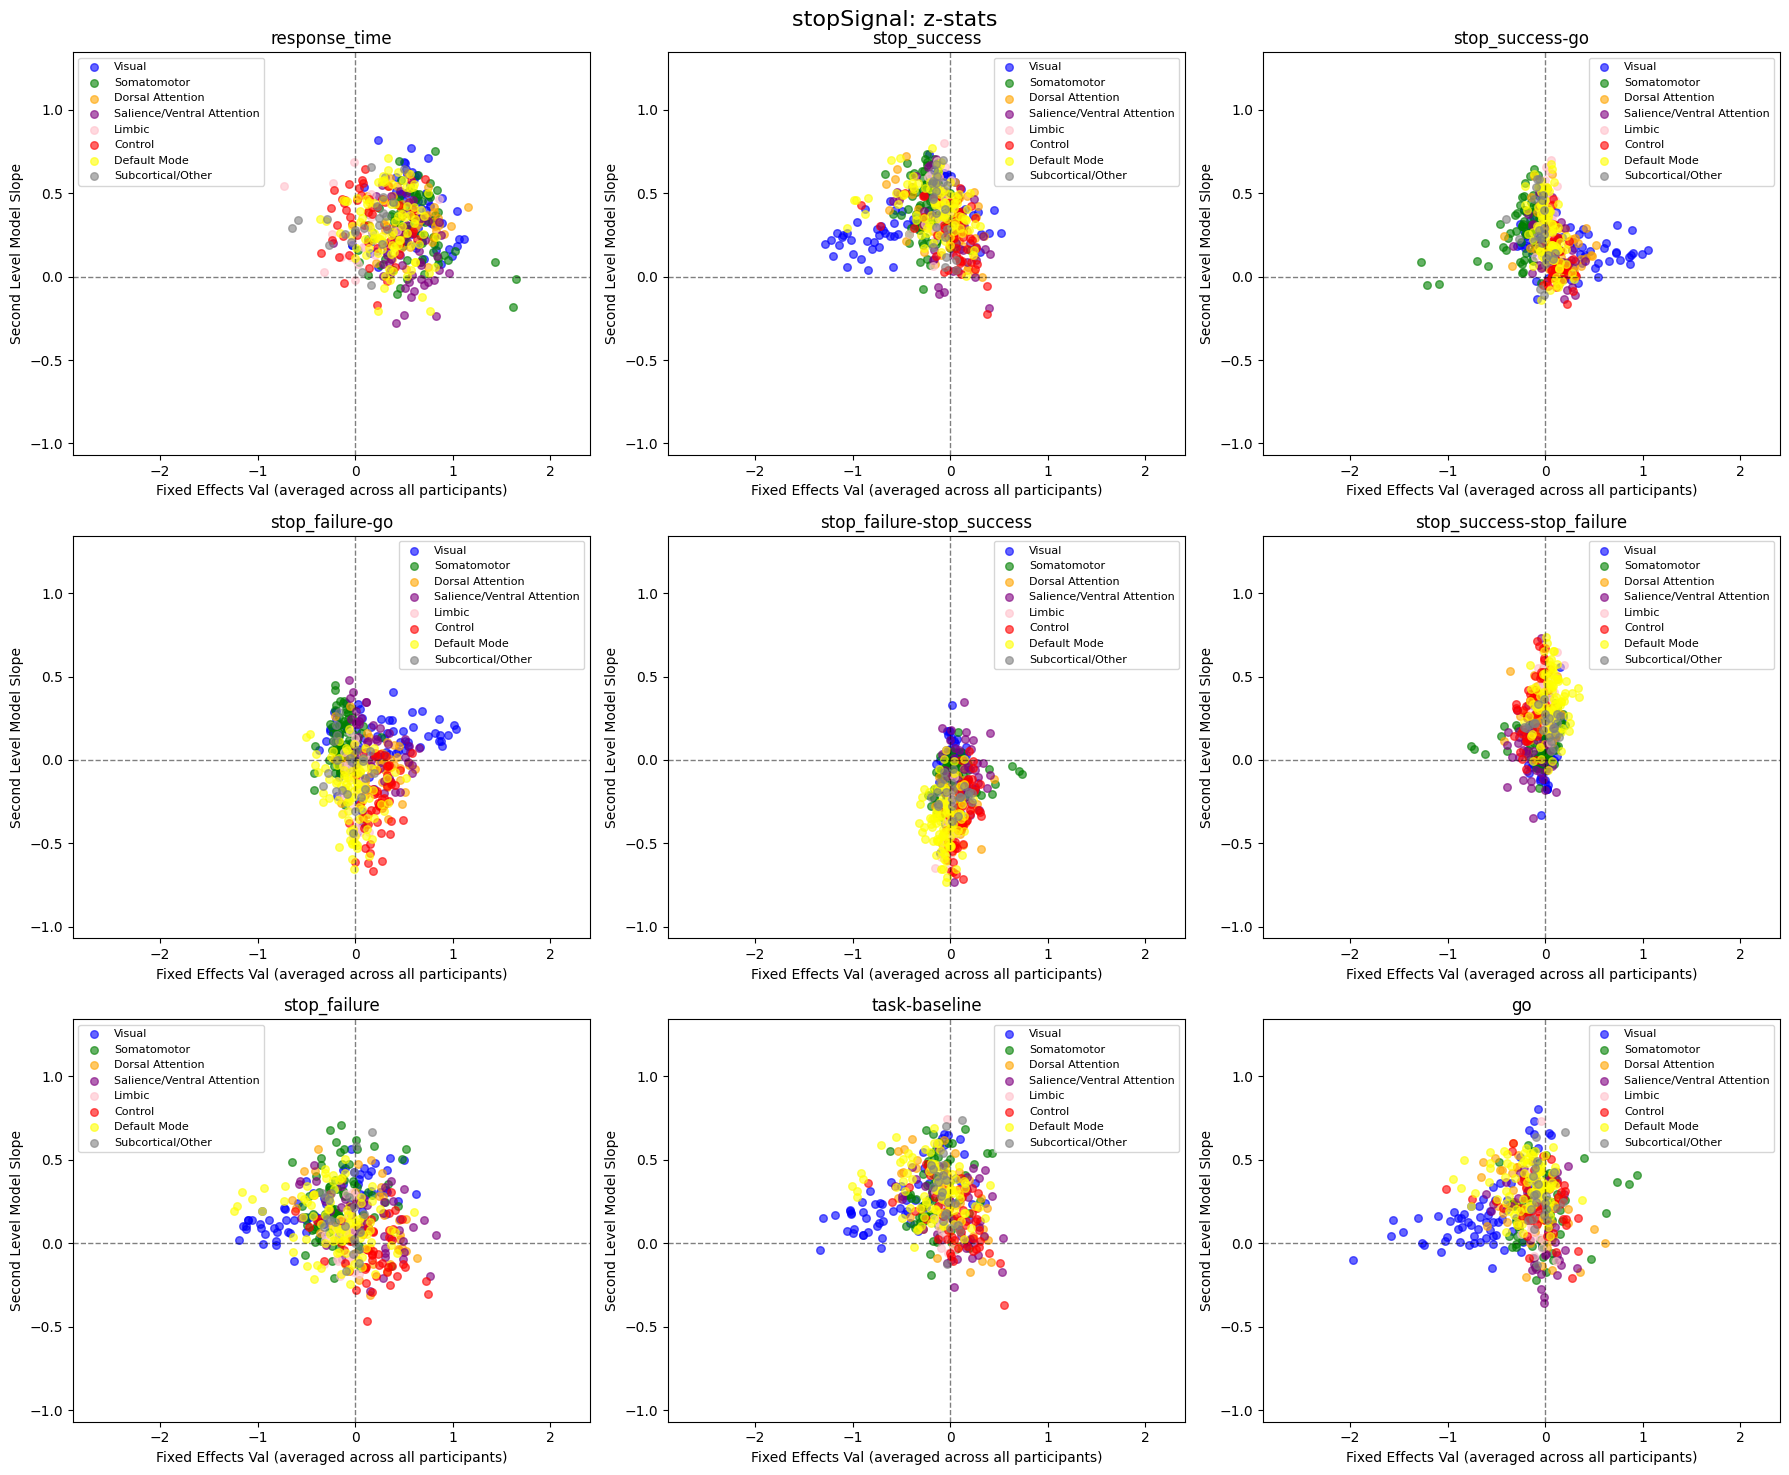

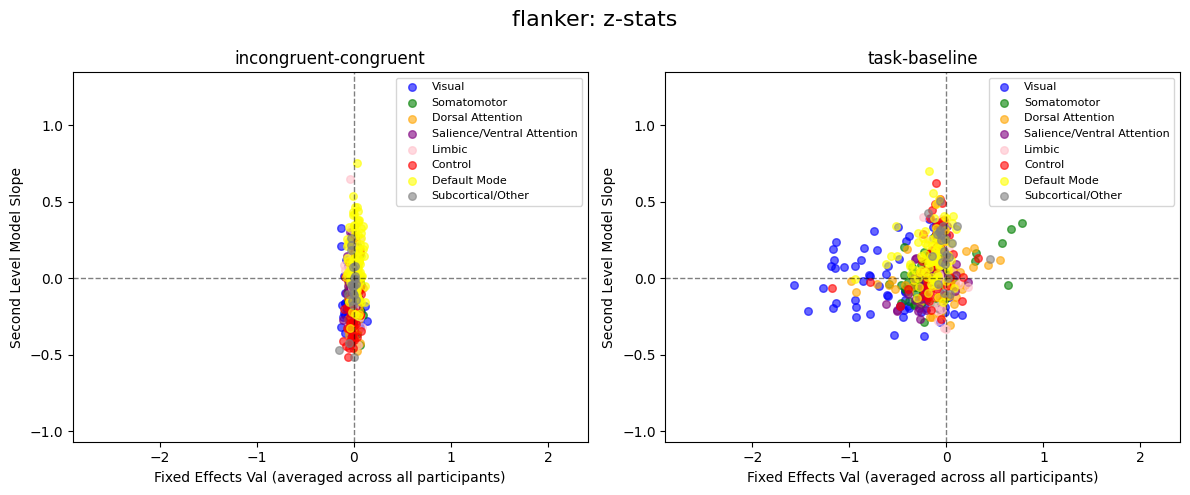

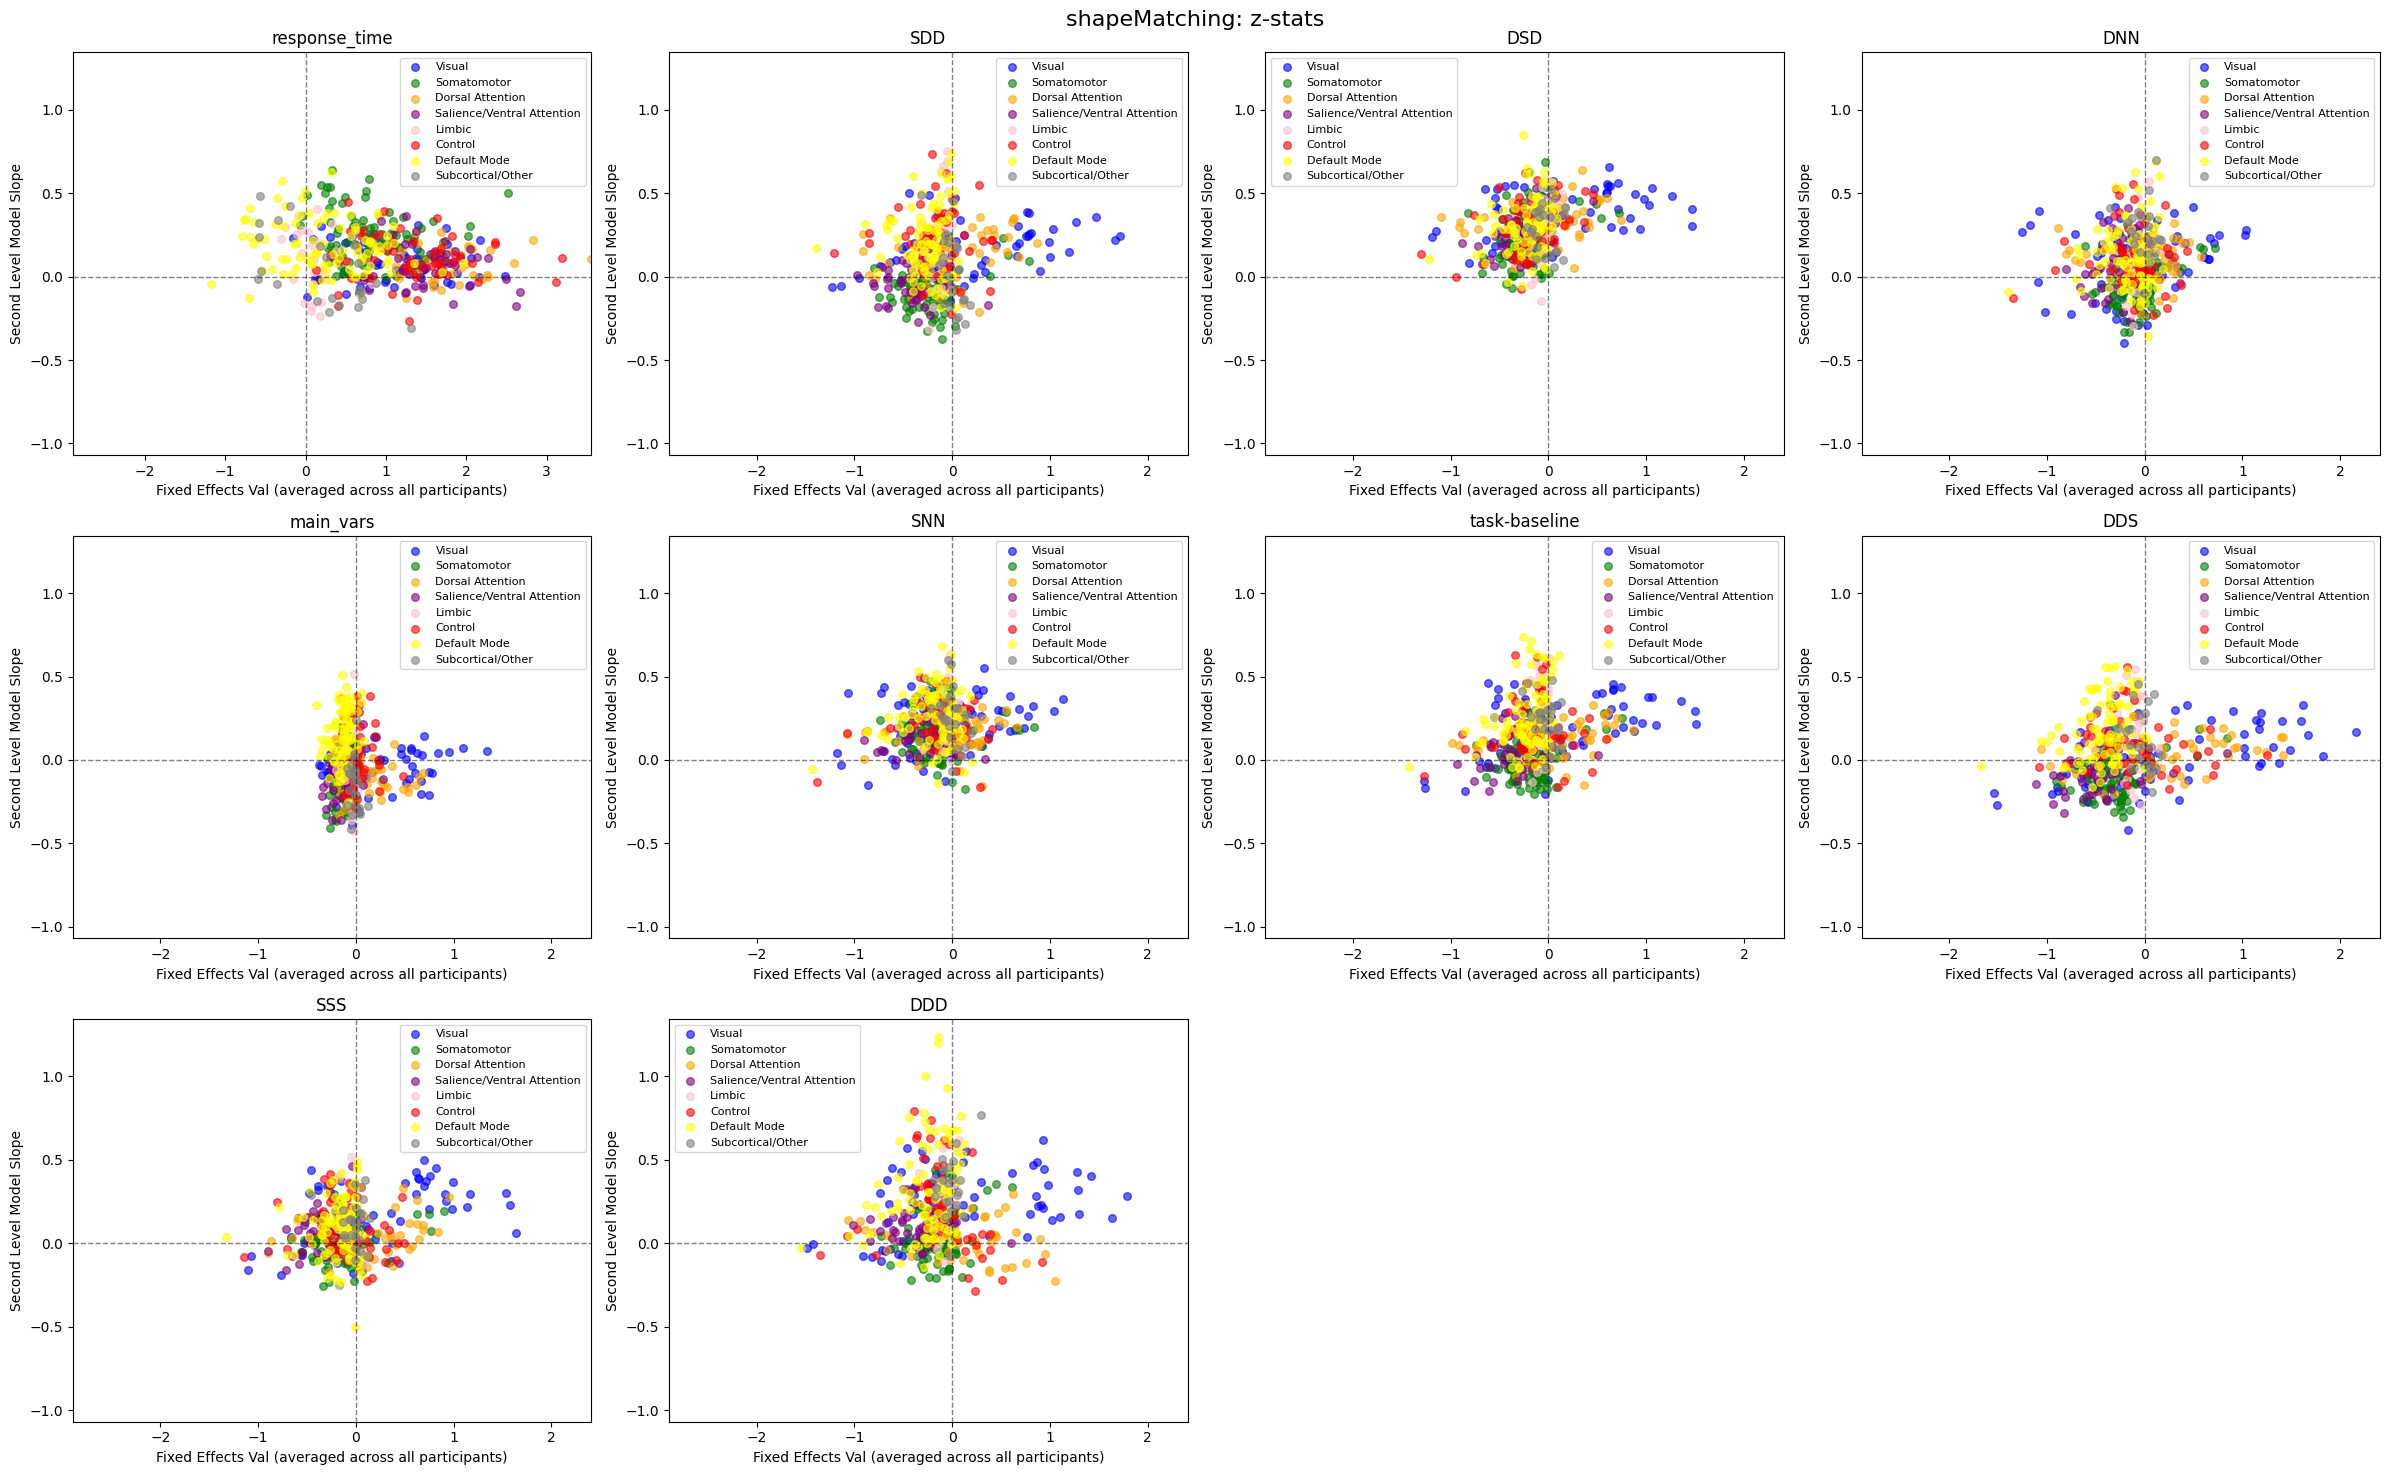

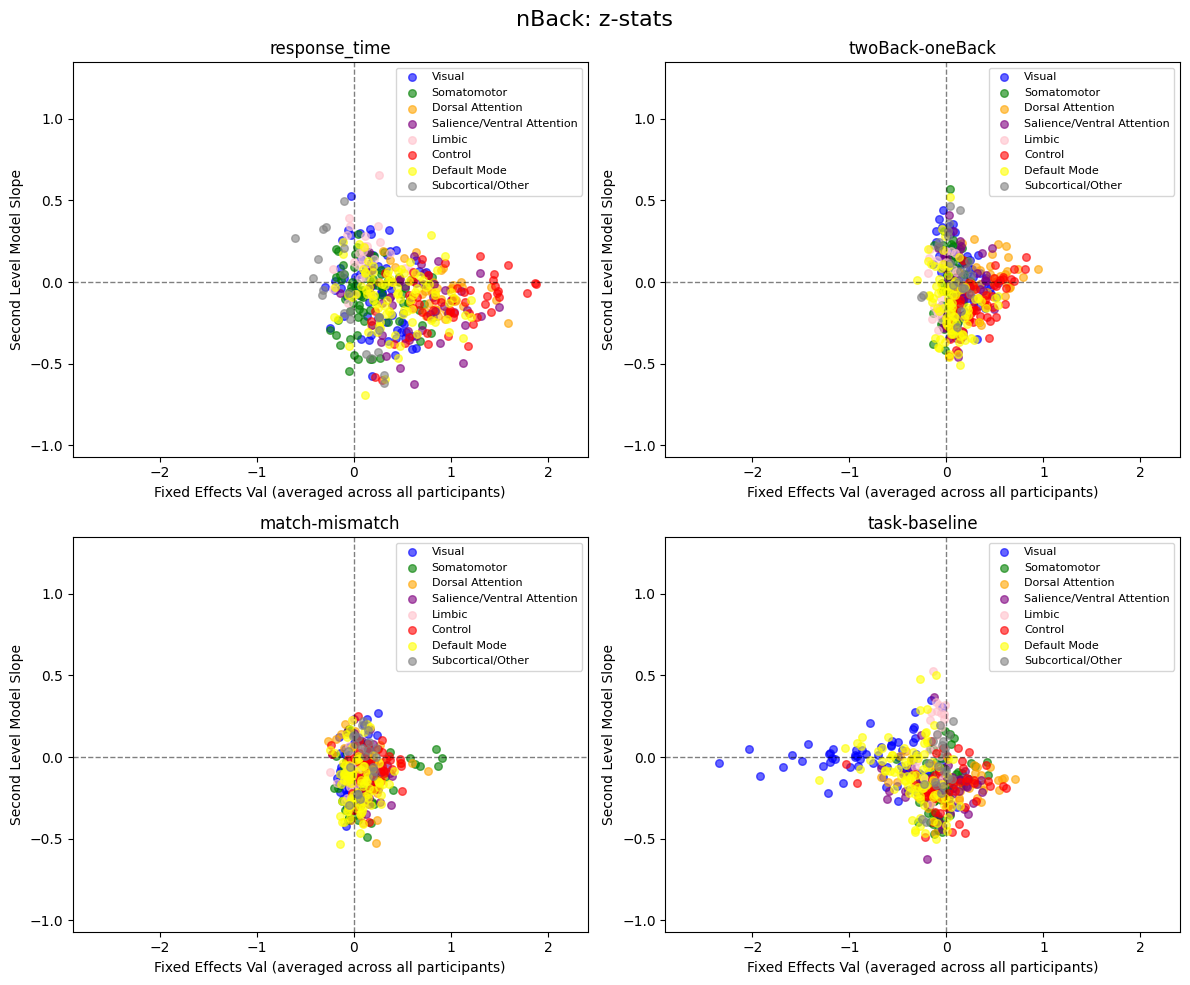

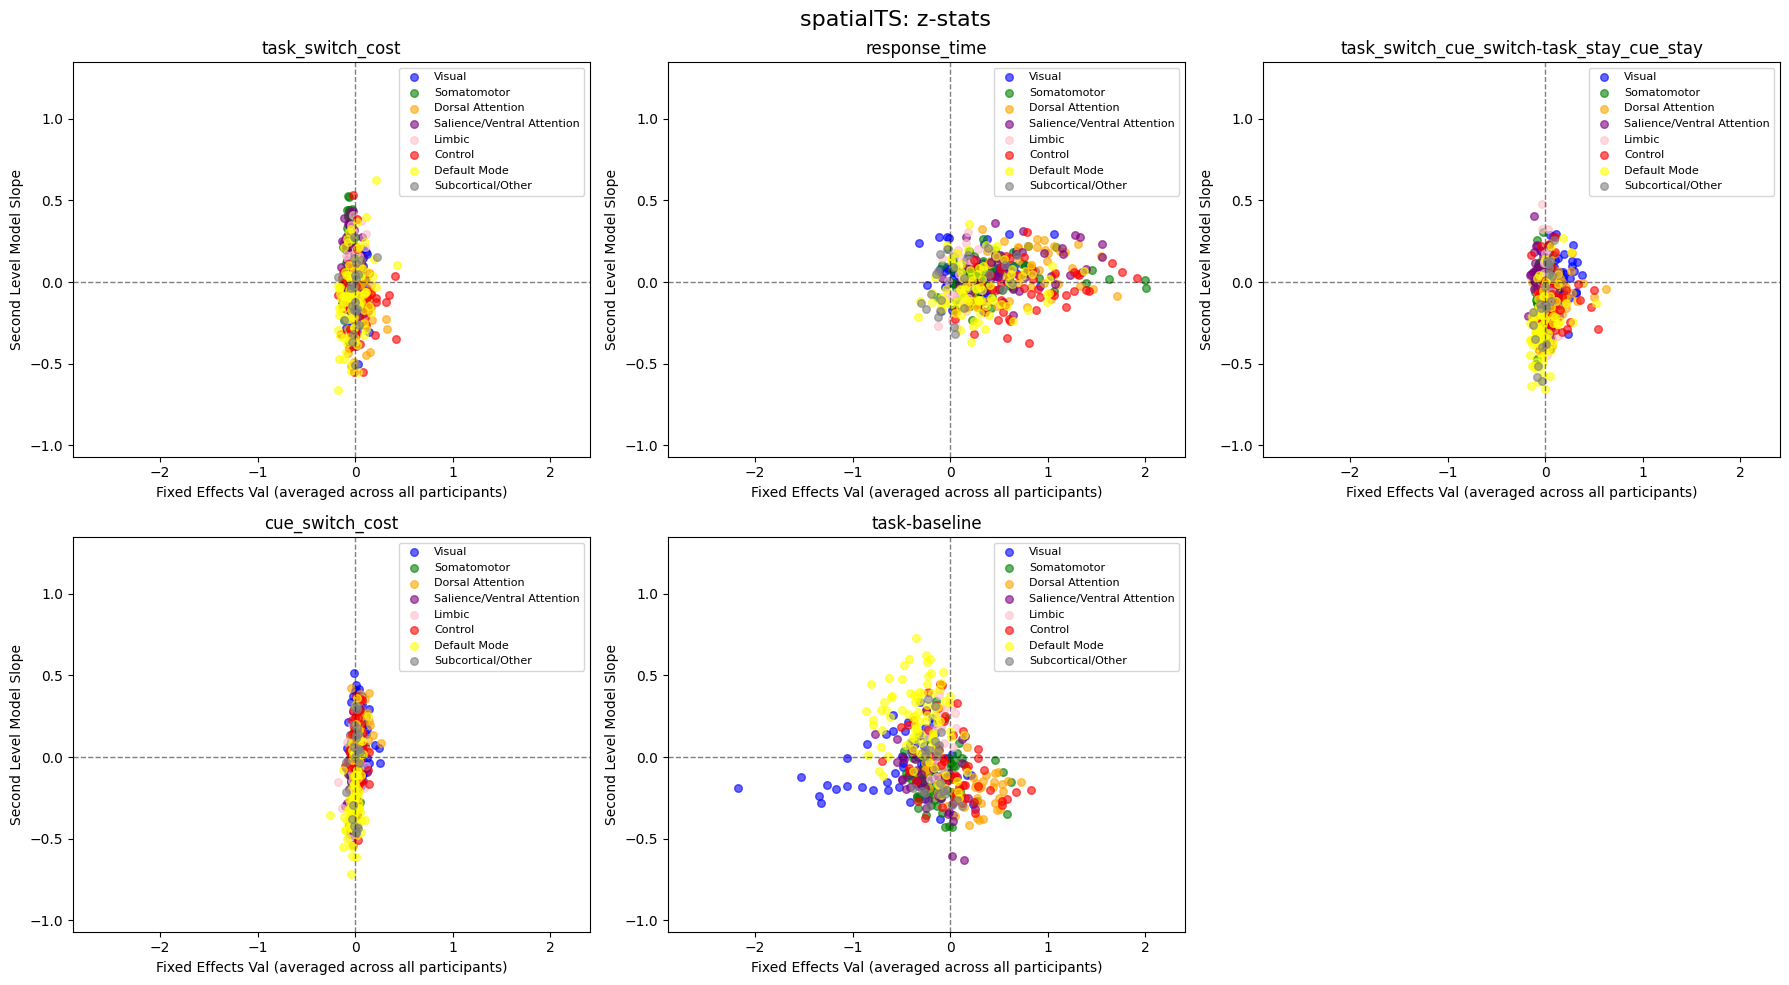

In [24]:
def get_network_category(parcel_name):
    if 'Vis' in parcel_name:
        return 'Visual'
    elif 'SomMot' in parcel_name:
        return 'Somatomotor'
    elif 'DorsAttn' in parcel_name:
        return 'Dorsal Attention'
    elif 'SalVentAttn' in parcel_name:
        return 'Salience/Ventral Attention'
    elif 'Limbic' in parcel_name:
        return 'Limbic'
    elif 'Cont' in parcel_name:
        return 'Control'
    elif 'Default' in parcel_name:
        return 'Default Mode'
    else:
        return 'Subcortical/Other'

# Create color mapping
network_colors = {
    'Visual': 'blue',
    'Somatomotor': 'green',
    'Dorsal Attention': 'orange',
    'Salience/Ventral Attention': 'purple',
    'Limbic': 'pink',
    'Control': 'red',
    'Default Mode': 'yellow',
    'Subcortical/Other': 'gray'
}

for task in avg_activations.keys():
    contrasts = list(avg_activations[task].keys())
    n_contrasts = len(contrasts)
    
    if n_contrasts <= 3:
        n_rows, n_cols = 1, n_contrasts
    elif n_contrasts <= 6:
        n_rows = 2
        n_cols = int(np.ceil(n_contrasts / 2))
    else:
        n_rows = 3
        n_cols = int(np.ceil(n_contrasts / 3))
    
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
    
    if n_contrasts == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    
    for idx, contrast in enumerate(contrasts):
        # Get network categories for each parcel
        parcels = list(second_level_parcel_slopes[task][contrast].keys())
        network_categories = [get_network_category(p) for p in parcels]
        
        # Plot each network separately for legend
        for network in network_colors.keys():
            mask = [cat == network for cat in network_categories]
            if any(mask):
                x_vals = [avg_activations[task][contrast]["avg_fixed_effects_val"][i] 
                         for i, m in enumerate(mask) if m]
                y_vals = [avg_activations[task][contrast]["second_level_slope"][i] 
                         for i, m in enumerate(mask) if m]
                
                axes[idx].scatter(x_vals, y_vals, 
                                c=network_colors[network], 
                                label=network, 
                                alpha=0.6, 
                                s=30)
        
        axes[idx].axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
        axes[idx].axvline(x=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
        axes[idx].set_title(f"{contrast}")
        axes[idx].set_xlabel("Fixed Effects Val (averaged across all participants)")
        axes[idx].set_ylabel("Second Level Model Slope")
        axes[idx].legend(fontsize=8, loc='best')
        if (contrast != "response_time"):
            axes[idx].set_xlim(x_min, x_max)
            axes[idx].set_ylim(y_min, y_max)
        else: 
            rt_max_x = max(x_max, np.max(avg_activations[task][contrast]["avg_fixed_effects_val"]))
            rt_max_y = max(y_max, np.max(avg_activations[task][contrast]["second_level_slope"]))
            rt_min_x = min(x_min, np.min(avg_activations[task][contrast]["avg_fixed_effects_val"]))
            rt_min_y = min(y_min, np.min(avg_activations[task][contrast]["second_level_slope"]))
            axes[idx].set_xlim(rt_min_x, rt_max_x)
            axes[idx].set_ylim(rt_min_y, rt_max_y)
    
    for idx in range(n_contrasts, len(axes)):
        axes[idx].set_visible(False)
    
    fig.suptitle(f"{task}: z-stats", fontsize=16)
    plt.tight_layout()
    plt.show()

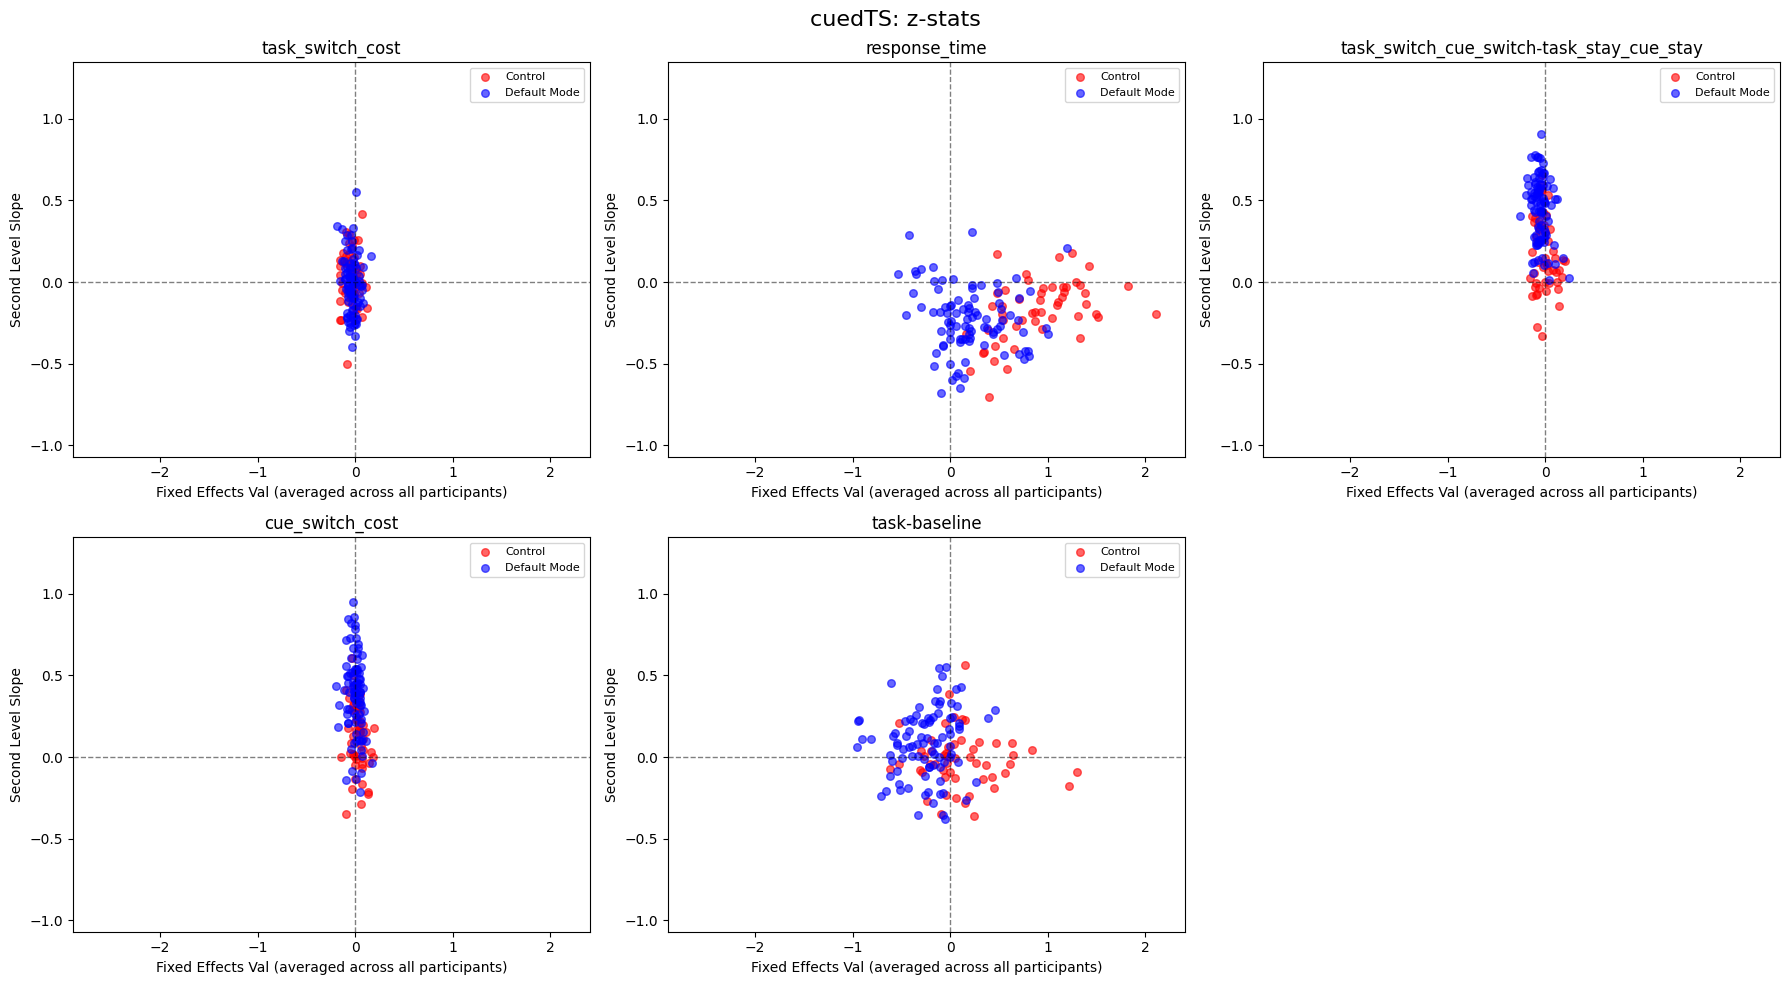

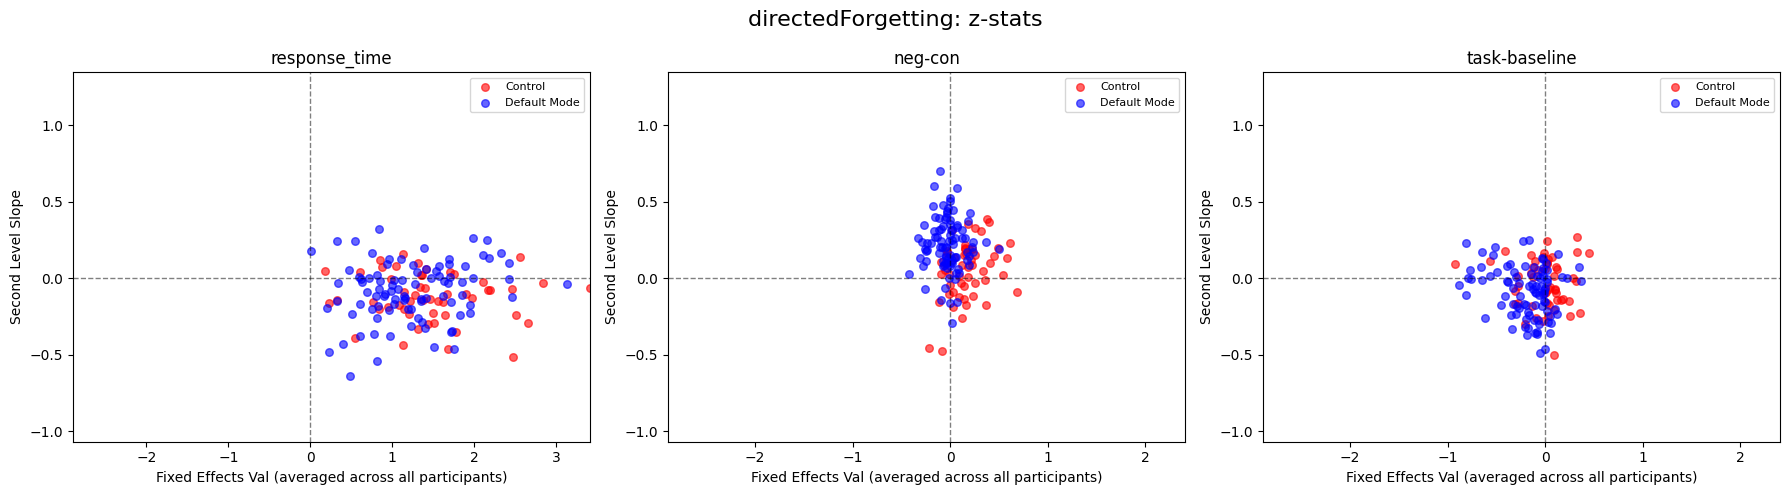

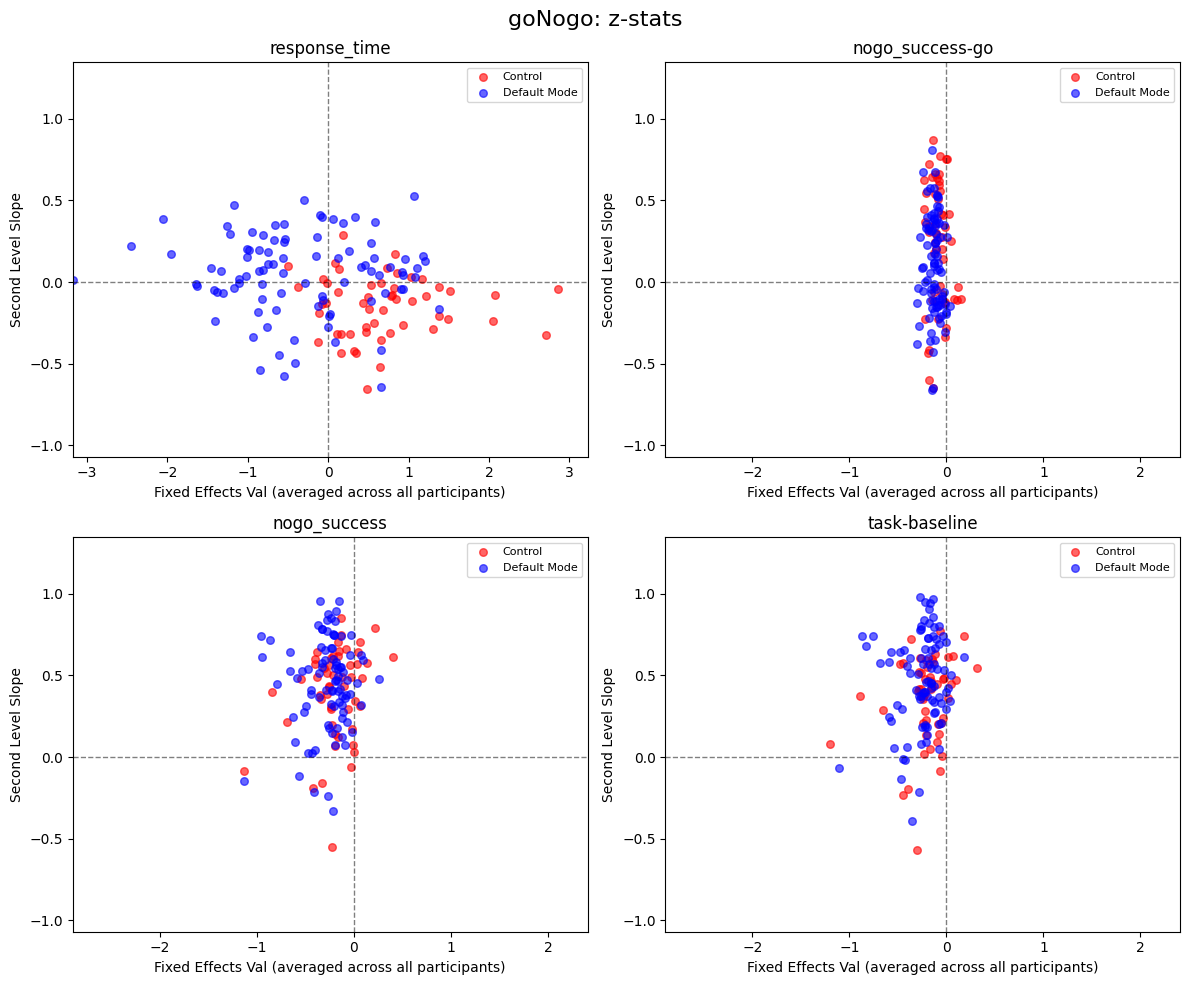

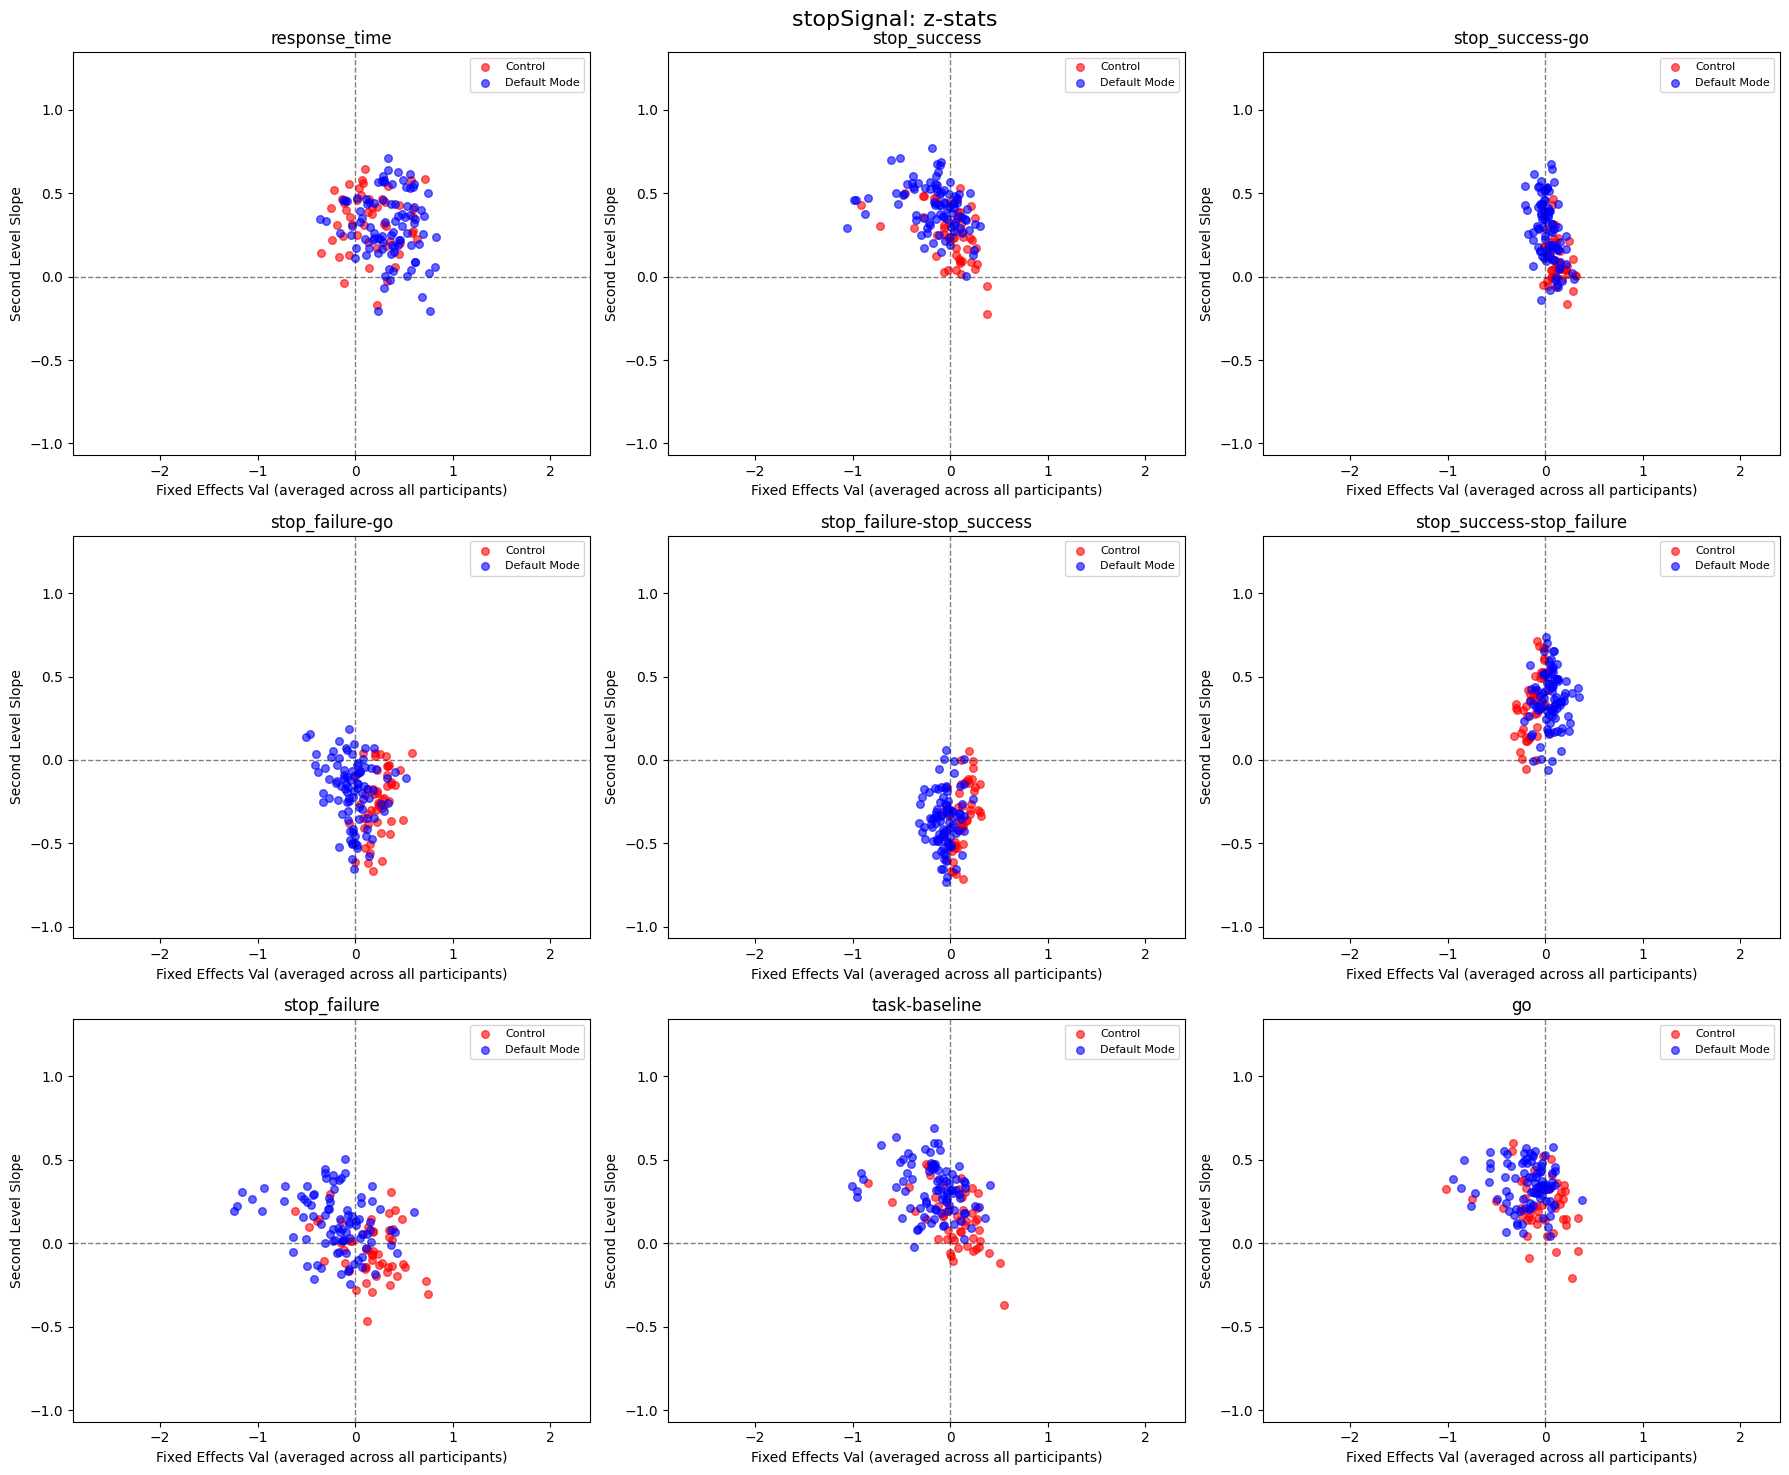

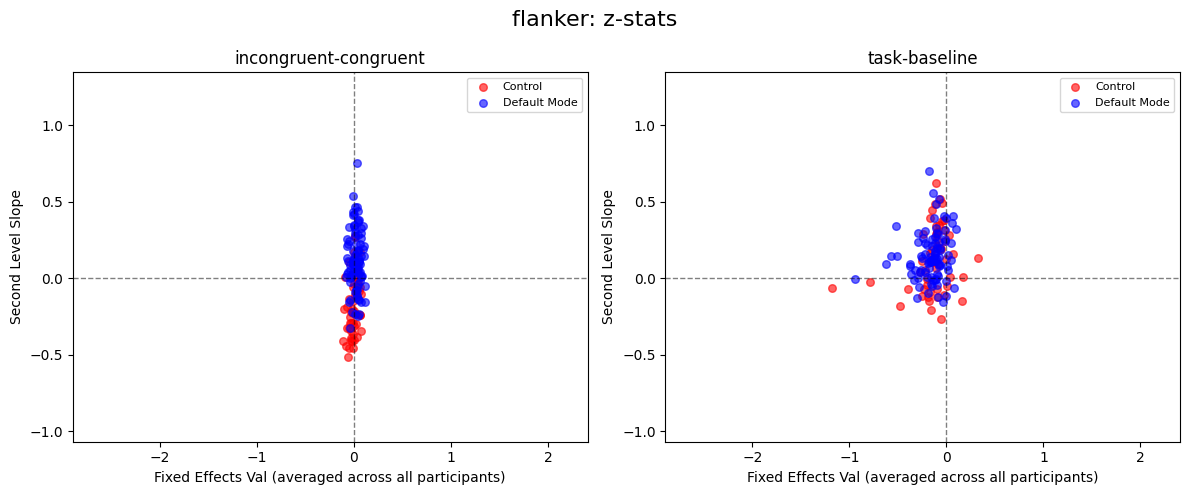

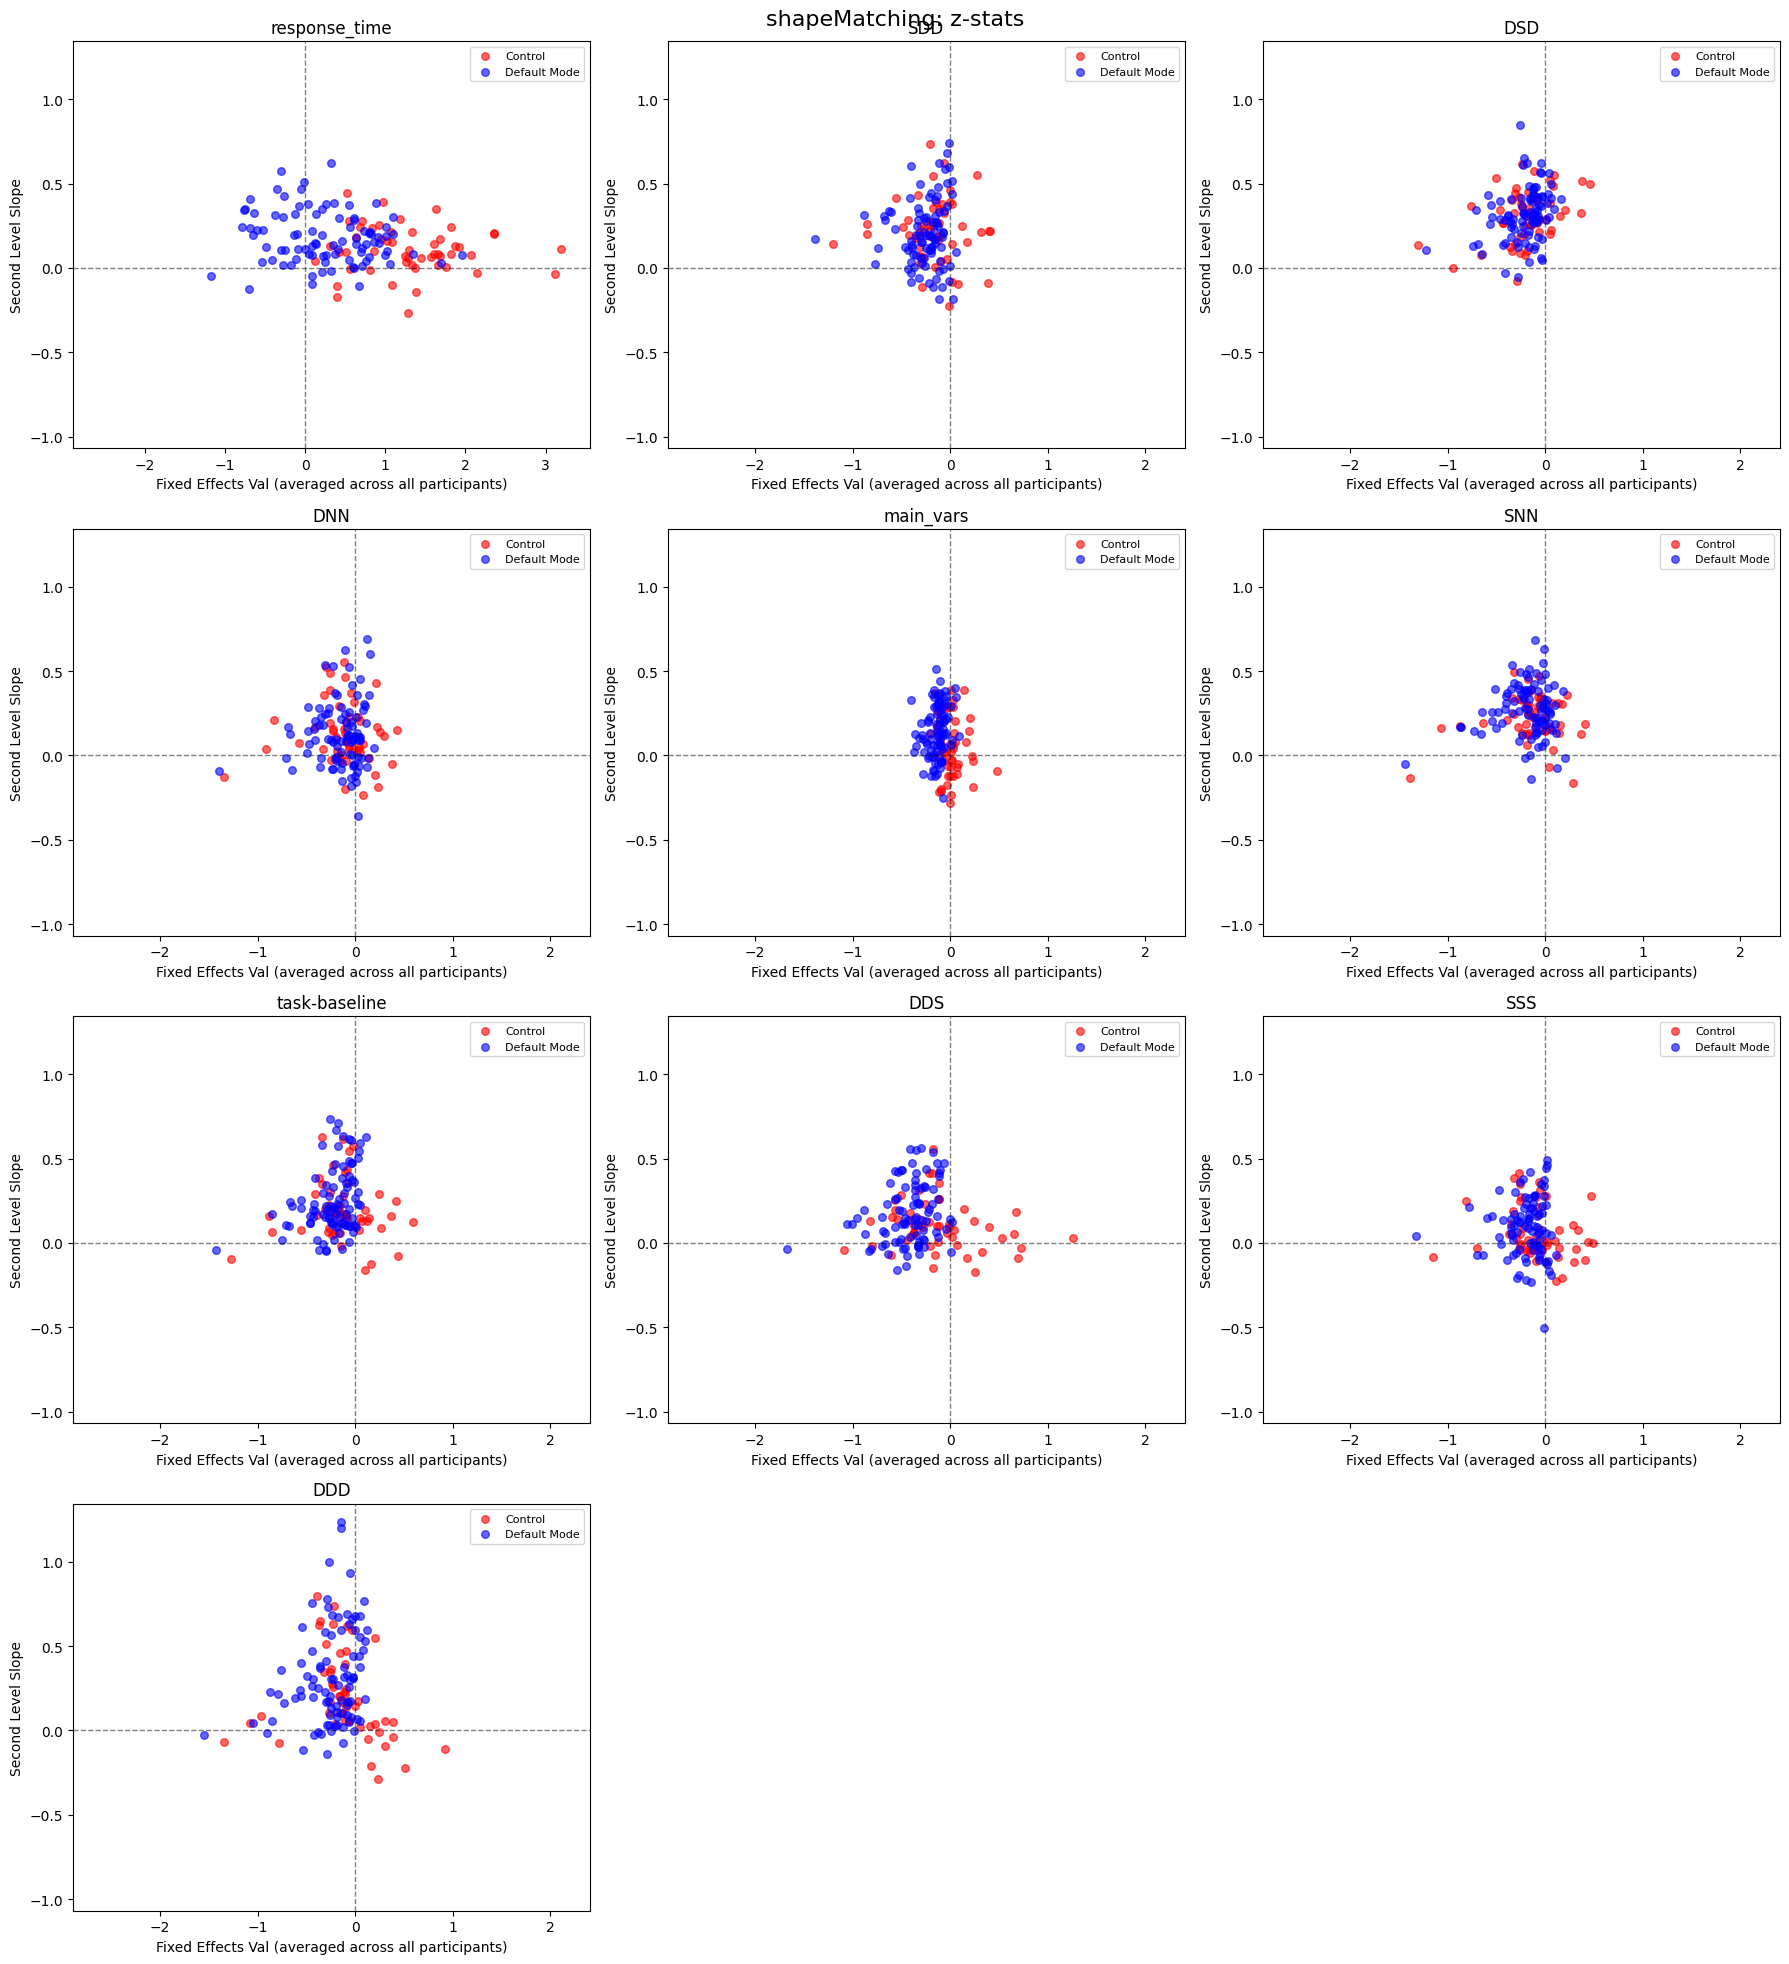

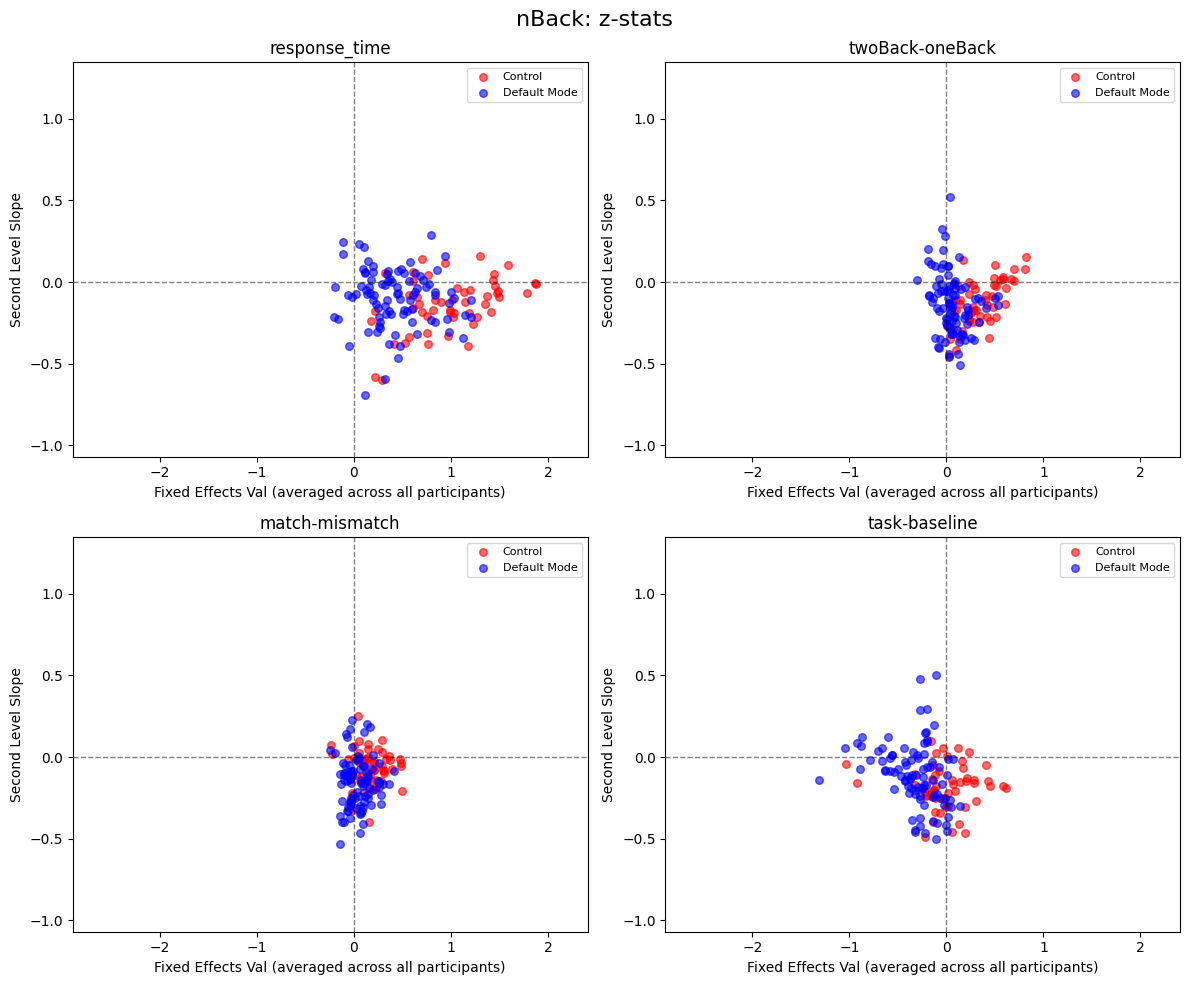

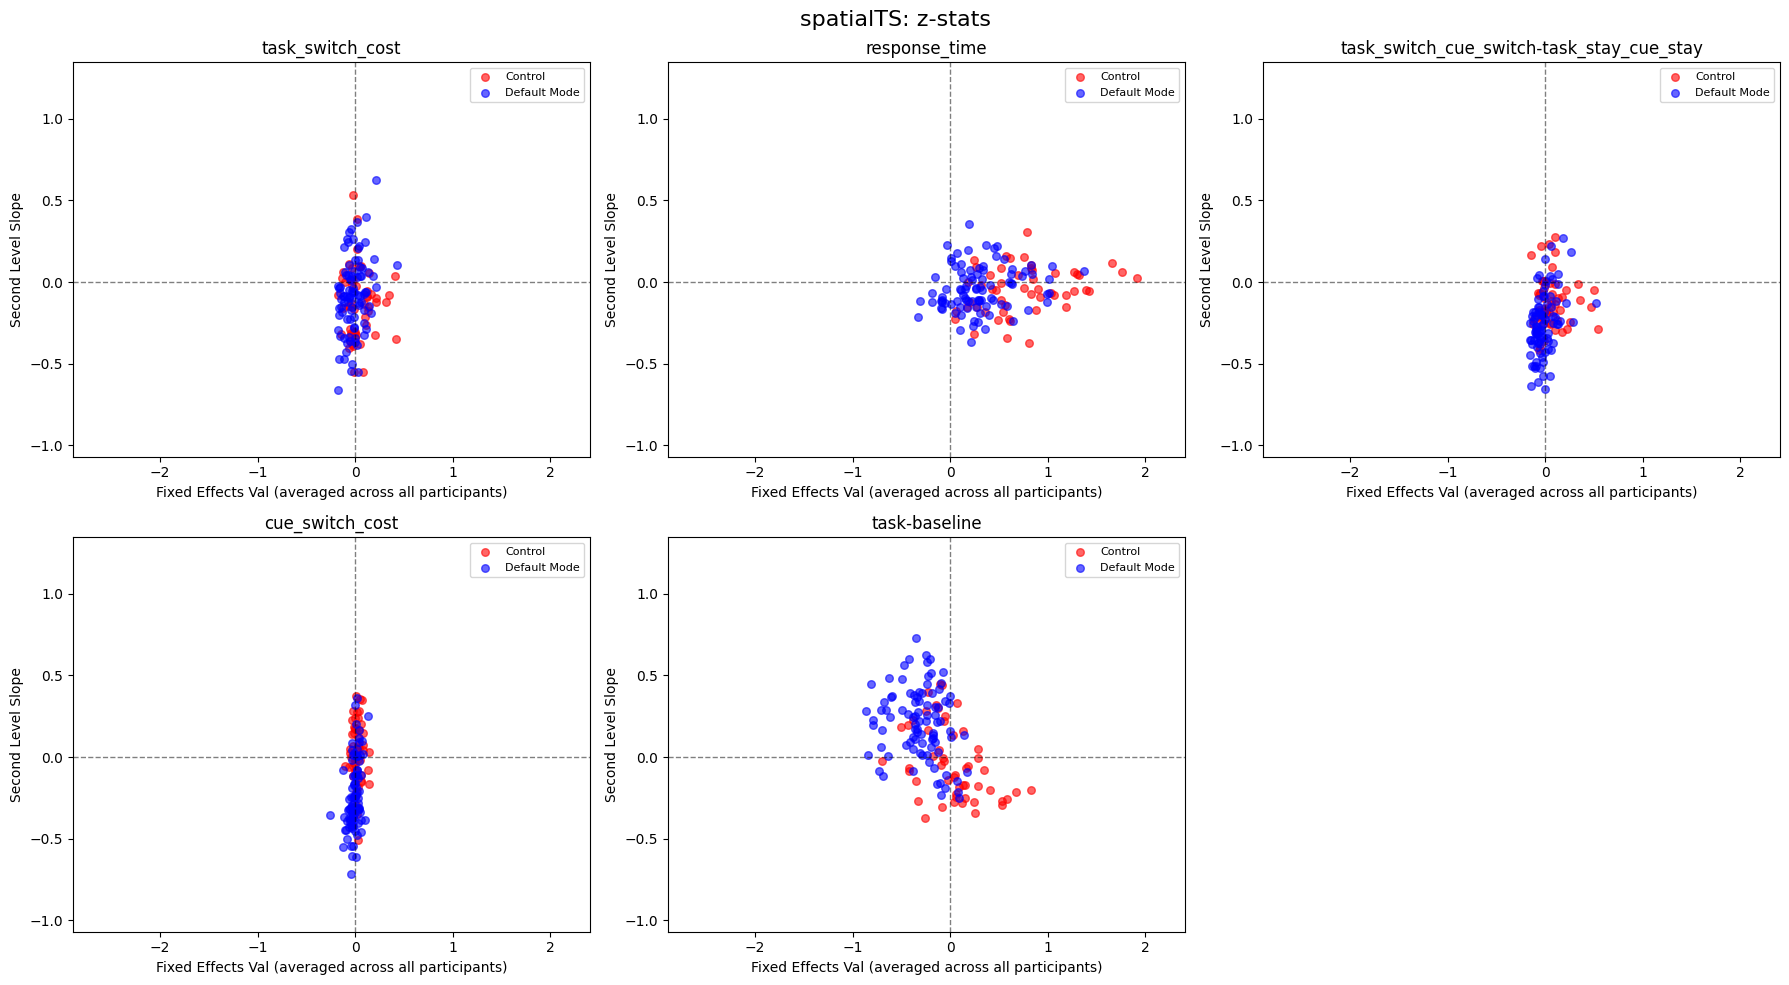

In [25]:
# plot only default mode and control regions
network_colors = {
    'Control': 'red',
    'Default Mode': 'blue'
}

for task in avg_activations.keys():
    contrasts = list(avg_activations[task].keys())
    n_contrasts = len(contrasts)
    
    if n_contrasts <= 3:
        n_rows, n_cols = 1, n_contrasts
    elif n_contrasts <= 6:
        n_rows = 2
        n_cols = int(np.ceil(n_contrasts / 2))
    elif n_contrasts <= 9:
        n_rows = 3
        n_cols = int(np.ceil(n_contrasts / 3))
    else:
        n_rows = 4
        n_cols = int(np.ceil(n_contrasts / 4))
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
    
    if n_contrasts == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    
    for idx, contrast in enumerate(contrasts):
        # Get network categories for each parcel
        parcels = list(second_level_parcel_slopes[task][contrast].keys())
        network_categories = [get_network_category(p) for p in parcels]
        
        # Plot only Control and Default Mode networks
        for network in network_colors.keys():
            mask = [cat == network for cat in network_categories]
            if any(mask):
                x_vals = [avg_activations[task][contrast]["avg_fixed_effects_val"][i] 
                         for i, m in enumerate(mask) if m]
                y_vals = [avg_activations[task][contrast]["second_level_slope"][i] 
                         for i, m in enumerate(mask) if m]
                
                axes[idx].scatter(x_vals, y_vals, 
                                c=network_colors[network], 
                                label=network, 
                                alpha=0.6, 
                                s=30)
        
        axes[idx].axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
        axes[idx].axvline(x=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
        axes[idx].set_title(f"{contrast}")
        axes[idx].set_xlabel("Fixed Effects Val (averaged across all participants)")
        axes[idx].set_ylabel("Second Level Slope")
        axes[idx].legend(fontsize=8, loc='best')
        if (contrast != "response_time"):
            axes[idx].set_xlim(x_min, x_max)
            axes[idx].set_ylim(y_min, y_max)
        else: 
            rt_max_x = max(x_max, np.max(avg_activations[task][contrast]["avg_fixed_effects_val"]))
            rt_max_y = max(y_max, np.max(avg_activations[task][contrast]["second_level_slope"]))
            rt_min_x = min(x_min, np.min(avg_activations[task][contrast]["avg_fixed_effects_val"]))
            rt_min_y = min(y_min, np.min(avg_activations[task][contrast]["second_level_slope"]))
            axes[idx].set_xlim(rt_min_x, rt_max_x)
            axes[idx].set_ylim(rt_min_y, rt_max_y)
    
    for idx in range(n_contrasts, len(axes)):
        axes[idx].set_visible(False)
    
    fig.suptitle(f"{task}: z-stats", fontsize=16)
    plt.tight_layout()
    plt.show()